In [51]:
!nvidia-smi # Checking GPU

Mon Sep 30 07:55:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [52]:
!pip install -q transformers # Installing the transformers library (https://huggingface.co/docs/transformers/index)

In [53]:
!pip install -q datasets # Installing the datasets library (https://huggingface.co/docs/datasets/index)

In [54]:
!pip install -q evaluate # Installing the evaluate library (https://huggingface.co/docs/evaluate/main/en/index)

In [55]:
!pip install -q rouge-score # Installing rouge-score library (https://pypi.org/project/rouge-score/)

In [56]:
!pip install -q py7zr # Installing library to save zip archives (https://pypi.org/project/py7zr/)

In [57]:
!pip install kaleido

In [58]:
!pip install -q datasets --upgrade
# upgrading datasets to the latest version
from datasets import load_dataset
from evaluate import load # importing load from evaluate
import pandas as pd
import numpy as np
import shutil

# Data Visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Statistics & Mathematics
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro, skew, anderson, kstest, gaussian_kde,spearmanr
import math

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

In [59]:
# Transformers
from transformers import BartTokenizer, BartForConditionalGeneration      # BERT Tokenizer and architecture
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments         # These will help us to fine-tune our model
from transformers import pipeline                                         # Pipeline
from transformers import DataCollatorForSeq2Seq                           # DataCollator to batch the data
import torch                                                              # PyTorch
import evaluate                                                           # Hugging Face's library for model evaluation


# Other NLP libraries
from textblob import TextBlob                                             # This is going to help us fix spelling mistakes in texts
from sklearn.feature_extraction.text import TfidfVectorizer               # This is going to helps identify the most common terms in the corpus
import re                                                                 # This library allows us to clean text data
import nltk                                                               # Natural Language Toolkit
nltk.download('punkt')                                                    # This divides a text into a list of sentences

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [60]:
# Configuring Pandas to exhibit larger columns
'''
This is going to allow us to fully read the dialogues and their summary
'''
pd.set_option('display.max_colwidth', 1000)

In [61]:
# Configuring notebook
seed = 42
#paper_color =
#bg_color =
colormap = 'cividis'
template = 'plotly_dark'

In [62]:
# Checking if GPU is available
if torch.cuda.is_available():
    print("GPU is available. \nUsing GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available. \nUsing CPU")
    device = torch.device('cpu')

GPU is available. 
Using GPU


In [63]:
def display_feature_list(features, feature_type):

    '''
    This function displays the features within each list for each type of data
    '''

    print(f"\n{feature_type} Features: ")
    print(', '.join(features) if features else 'None')

def describe_df(df):
    """
    This function prints some basic info on the dataset and
    sets global variables for feature lists.
    """

    global categorical_features, continuous_features, binary_features
    categorical_features = [col for col in df.columns if df[col].dtype == 'object']
    binary_features = [col for col in df.columns if df[col].nunique() <= 2 and df[col].dtype != 'object']
    continuous_features = [col for col in df.columns if df[col].dtype != 'object' and col not in binary_features]

    print(f"\n{type(df).__name__} shape: {df.shape}")
    print(f"\n{df.shape[0]:,.0f} samples")
    print(f"\n{df.shape[1]:,.0f} attributes")
    print(f'\nMissing Data: \n{df.isnull().sum()}')
    print(f'\nDuplicates: {df.duplicated().sum()}')
    print(f'\nData Types: \n{df.dtypes}')

    #negative_valued_features = [col for col in df.columns if (df[col] < 0).any()]
    #print(f'\nFeatures with Negative Values: {", ".join(negative_valued_features) if negative_valued_features else "None"}')

    display_feature_list(categorical_features, 'Categorical')
    display_feature_list(continuous_features, 'Continuous')
    display_feature_list(binary_features, 'Binary')

    print(f'\n{type(df).__name__} Head: \n')
    display(df.head(5))
    print(f'\n{type(df).__name__} Tail: \n')
    display(df.tail(5))

In [81]:
from IPython.display import Image, display

pio.kaleido.scope.default_format = "png"

def histogram_boxplot(df,hist_color, box_color, height, width, legend, name):
    '''
    This function plots a Histogram and a Box Plot side by side

    Parameters:
    hist_color = The color of the histogram
    box_color = The color of the boxplots
    heigh and width = Image size
    legend = Either to display legend or not
    '''

    features = df.select_dtypes(include = [np.number]).columns.tolist()

    for feat in features:
        try:
            fig = make_subplots(
                rows=1,
                cols=2,
                subplot_titles=["Box Plot", "Histogram"],
                horizontal_spacing=0.2
            )

            density = gaussian_kde(df[feat])
            x_vals = np.linspace(min(df[feat]), max(df[feat]), 200)
            density_vals = density(x_vals)

            fig.add_trace(go.Scatter(x=x_vals, y = density_vals, mode = 'lines',
                                     fill = 'tozeroy', name="Density", line_color=hist_color), row=1, col=2)
            fig.add_trace(go.Box(y=df[feat], name="Box Plot", boxmean=True, line_color=box_color), row=1, col=1)

            fig.update_layout(title={'text': f'<b>{name} Word Count<br><sup><i>&nbsp;&nbsp;&nbsp;&nbsp;{feat}</i></sup></b>',
                                     'x': .025, 'xanchor': 'left'},
                             margin=dict(t=100),
                             showlegend=legend,
                             template = template,
                             #plot_bgcolor=bg_color,paper_bgcolor=paper_color,
                             height=height, width=width
                            )

            fig.update_yaxes(title_text=f"<b>Words</b>", row=1, col=1, showgrid=False)
            fig.update_xaxes(title_text="", row=1, col=1, showgrid=False)

            fig.update_yaxes(title_text="<b>Frequency</b>", row=1, col=2,showgrid=False)
            fig.update_xaxes(title_text=f"<b>Words</b>", row=1, col=2, showgrid=False)

            fig.write_image(f"{name}_plots.png")
            display(Image(f"/kaggle/working/{name}_plots.png"))
            
            print('\n')
        except Exception as e:
            print(f"An error occurred: {e}")

In [83]:
def plot_correlation(df, title, subtitle, height, width, font_size):
    '''
    This function is resposible to plot a correlation map among features in the dataset.

    Parameters:
    height = Define height
    width = Define width
    font_size = Define the font size for the annotations
    '''
    corr = np.round(df.corr(numeric_only = True), 2)
    mask = np.triu(np.ones_like(corr, dtype = bool))
    c_mask = np.where(~mask, corr, 100)

    c = []
    for i in c_mask.tolist()[1:]:
        c.append([x for x in i if x != 100])



    fig = ff.create_annotated_heatmap(z=c[::-1],
                                      x=corr.index.tolist()[:-1],
                                      y=corr.columns.tolist()[1:][::-1],
                                      colorscale = colormap)

    fig.update_layout(title = {'text': f"<b>{title} Heatmap<br><sup>&nbsp;&nbsp;&nbsp;&nbsp;<i>{subtitle}</i></sup></b>",
                                'x': .025, 'xanchor': 'left', 'y': .95},
                    margin = dict(t=210, l = 110),
                    yaxis = dict(autorange = 'reversed', showgrid = False),
                    xaxis = dict(showgrid = False),
                    template = template,
                    #plot_bgcolor=bg_color,paper_bgcolor=paper_color,
                    height = height, width = width)


    fig.add_trace(go.Heatmap(z = c[::-1],
                             colorscale = colormap,
                             showscale = True,
                             visible = False))
    fig.data[1].visible = True

    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i].font.size = font_size

    fig.write_image(f"{title}_{subtitle}_heatmap.png")
    display(Image(f"/kaggle/working/{title}_{subtitle}_heatmap.png"))
    

In [66]:
def compute_tfidf(df_column, ngram_range=(1,1), max_features=15):
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english', ngram_range=ngram_range)
    x = vectorizer.fit_transform(df_column.fillna(''))
    df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
    return df_tfidfvect

<div id = 'eda'
     style="font-family: Calibri, serif; text-align: left;">
    <hr style="border: none;
               border-top: 2.85px solid #041445;
               width: 100%;
               margin-top: 62px;
               margin-bottom: auto;
               margin-left: 0;">
    <div style="font-size: 35px; letter-spacing: 2.25px;color: #02011a;"><b>Exploring the Dataset</b></div>
</div>

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">We can start our analysis of the dataset by loading all the three sets available, <code>train</code>, <code>test</code>, and <code>val</code>.</p>

In [67]:
# Loading data
train = pd.read_csv('/kaggle/input/samsum-dataset/samsum-train.csv')
test = pd.read_csv('/kaggle/input/samsum-dataset/samsum-test.csv')
val = pd.read_csv('/kaggle/input/samsum-dataset/samsum-validation.csv')

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">I am now going to analyze each dataset separately.</p>

<div id = 'train'
     style="font-family: Calibri, serif; text-align: left;">
    <hr style="border: none;
               width: 100%;
               margin-top: 62px;
               margin-bottom: auto;
               margin-left: 0;">
    <div style="font-size: 35px; letter-spacing: 2.25px;color: #02011a;"><b>Train Dataset</b></div>
</div>

In [68]:
# Extracting info on the training Dataframe
describe_df(train)


DataFrame shape: (14732, 3)

14,732 samples

3 attributes

Missing Data: 
id          0
dialogue    1
summary     0
dtype: int64

Duplicates: 0

Data Types: 
id          object
dialogue    object
summary     object
dtype: object

Categorical Features: 
id, dialogue, summary

Continuous Features: 
None

Binary Features: 
None

DataFrame Head: 



,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-),Amanda baked cookies and will bring Jerry some tomorrow.
1,13728867,Olivia: Who are you voting for in this election? \r\nOliver: Liberals as always.\r\nOlivia: Me too!!\r\nOliver: Great,Olivia and Olivier are voting for liberals in this election.
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating\r\nTim: What did you plan on doing?\r\nKim: Oh you know, uni stuff and unfucking my room\r\nKim: Maybe tomorrow I'll move my ass and do everything\r\nKim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies\r\nTim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores\r\nTim: It really helps\r\nKim: thanks, maybe I'll do that\r\nTim: I also like using post-its in kaban style",Kim may try the pomodoro technique recommended by Tim to get more stuff done.
3,13730747,"Edward: Rachel, I think I'm in ove with Bella..\r\nrachel: Dont say anything else..\r\nEdward: What do you mean??\r\nrachel: Open your fu**ing door.. I'm outside",Edward thinks he is in love with Bella. Rachel wants Edward to open his door. Rachel is outside.
4,13728094,"Sam: hey overheard rick say something\r\nSam: i don't know what to do :-/\r\nNaomi: what did he say??\r\nSam: he was talking on the phone with someone\r\nSam: i don't know who\r\nSam: and he was telling them that he wasn't very happy here\r\nNaomi: damn!!!\r\nSam: he was saying he doesn't like being my roommate\r\nNaomi: wow, how do you feel about it?\r\nSam: i thought i was a good rommate\r\nSam: and that we have a nice place\r\nNaomi: that's true man!!!\r\nNaomi: i used to love living with you before i moved in with me boyfriend\r\nNaomi: i don't know why he's saying that\r\nSam: what should i do???\r\nNaomi: honestly if it's bothering you that much you should talk to him\r\nNaomi: see what's going on\r\nSam: i don't want to get in any kind of confrontation though\r\nSam: maybe i'll just let it go\r\nSam: and see how it goes in the future\r\nNaomi: it's your choice sam\r\nNaomi: if i were you i would just talk to him and clear the air","Sam is confused, because he overheard Rick complaining about him as a roommate. Naomi thinks Sam should talk to Rick. Sam is not sure what to do."



DataFrame Tail: 



,id,dialogue,summary
14727,13863028,"Romeo: You are on my ‘People you may know’ list.\nGreta: Ah, maybe it is because of the changed number of somebody’s?\nGreta: I don’t know you?\nRomeo: This might be the beginning of a beautiful relationship\nRomeo: How about adding me on your friend list and talk a bit?\nGreta: No.\nRomeo: Okay I see.",Romeo is trying to get Greta to add him to her friend list but she refuses.
14728,13828570,"Theresa: <file_photo>\r\nTheresa: <file_photo>\r\nTheresa: Hey Louise, how are u?\r\nTheresa: This is my workplace, they always give us so much food here 😊\r\nTheresa: Luckily they also offer us yoga classes, so all the food isn't much of a problem 😂\r\nLouise: Hey!! 🙂 \r\nLouise: Wow, that's awesome, seems great 😎 Haha\r\nLouise: I'm good! Are you coming to visit Stockholm this summer? 🙂\r\nTheresa: I don't think so :/ I need to prepare for Uni.. I will probably attend a few lessons this winter\r\nLouise: Nice! Do you already know which classes you will attend?\r\nTheresa: Yes, it will be psychology :) I want to complete a few modules that I missed :)\r\nLouise: Very good! Is it at the Uni in Prague?\r\nTheresa: No, it will be in my home town :)\r\nLouise: I have so much work right now, but I will continue to work until the end of summer, then I'm also back to Uni, on the 26th September!\r\nTheresa: You must send me some pictures, so I can see where you live :) \r\nLouise: I will,...","Theresa is at work. She gets free food and free yoga classes. Theresa won't go to visit Louise in Stockholm, because she will prepare for university psychology lessons. She'll be back at uni on 26th September."
14729,13819050,"John: Every day some bad news. Japan will hunt whales again\r\nErica: Yes, I've read this. It's very upsetting\r\nJohn: Cruel Japanese\r\nFaith: I think this is a racist remark. Because Island and Norways has never joined this international whaling agreement\r\nErica: really? I haven't known, everybody is so outraged by Japan\r\nFaith: sure, European hypocrisy \r\nJohn: not entirely. Scandinavians don't use the nets that Japanese use, so Norway and Island kill much less specimens that Japan will\r\nFaith: oh, it's much more complex than one may expect\r\nJohn: True, but the truth is, that all of them should stop\r\nJohn: and this decision is a step back\r\nFaith: yes, this is worrying\r\nErica: And it seems that the most important whaling countries are out of the agreement right now\r\nFaith: yes, seems so\r\nJohn: Just like USA leaving the Paris Agreement",Japan is going to hunt whales again. Island and Norway never stopped hunting them. The Scandinavians kill fewer whales than the Japanese.
14730,13828395,"Jennifer: Dear Celia! How are you doing?\r\nJennifer: The afternoon with the Collins was very pleasant, nice folks, but we missed you.\r\nJennifer: But I appreciate your consideration for Peter.\r\nCelia: My dear Jenny! It turns out that my decision not to come, though I wanted so much to see you again and Peter and the Collins, was right. Yesterday it all developed into a full bore cold. Sh.....\r\nCelia: All symptoms like in a text book.\r\nCelia: Luckily it's contagious only on the first 2, 3 days, so when we meet next week it should be alright.\r\nCelia: Thanks for asking! Somehow for all of us Peter comes first now.\r\nJennifer: That's too bad. Poor you...\r\nJennifer: I'll be driving to FR, do you want me to bring you sth? It's on my way.\r\nCelia: Thank you dear! I was at the pharmacy yesterday and had done my shopping the day before.\r\nCelia: You'd better still stay away from me in case I'm still contagious\r\nJennifer: Right. So I'll only leave a basket on your terrace. A...","Celia couldn't make it to the afternoon with the Collins and Jennifer as she is ill. She's working, but doesn't want to meet with Jennifer as it might be contagious. Jennifer will leave a basket with cookies on Celia's terrace."
14731,13729017,"Georgia: are you ready for hotel hunting? We need to book somethin

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">We have 14,732 pairs of dialogues and summaries. It also seems like one of the dialogues is empty, let's investigate it further.</p>

In [69]:
mask = train['dialogue'].isnull() # Creating mask with null dialogues
filtered_train = train[mask] # filtering dataframe
filtered_train # Visualizing

,id,dialogue,summary
6054,13828807,NaN,problem with visualization of the content


<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">It seems that sample <b>6054</b> does not really add anything to the dataset. We have a Null dialogue and the summary does not give us a clue on what this dialogue was supposed to be. We will remove this entry.</p>

In [70]:
train = train.dropna() # removing null values

In [71]:
# Removing 'Id' from categorical features list
categorical_features.remove('id')

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">We can now analyze the length of both dialogues and summaries by counting the words in them. This might give us a clue about how these texts are structured.</p>

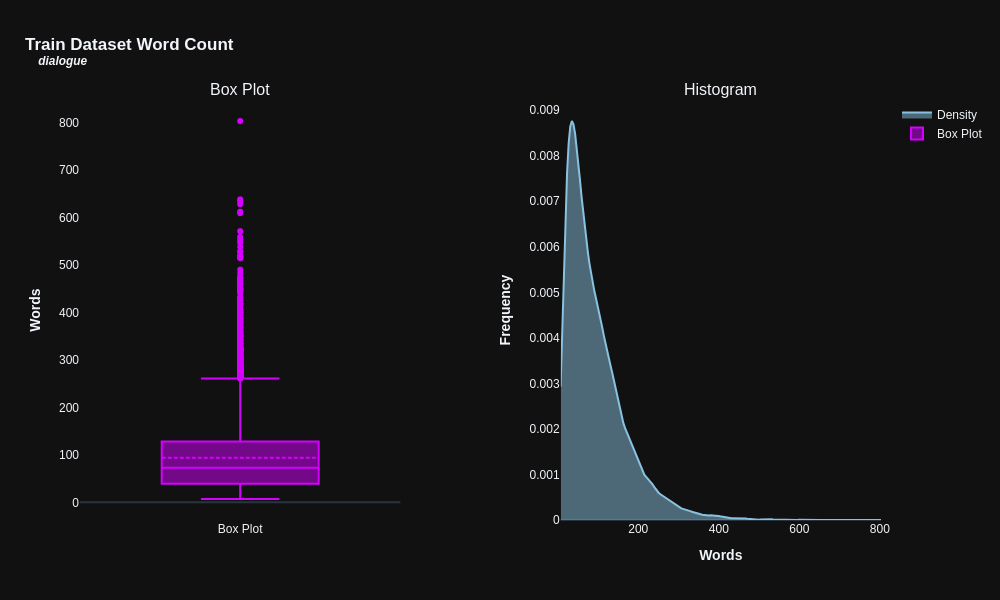

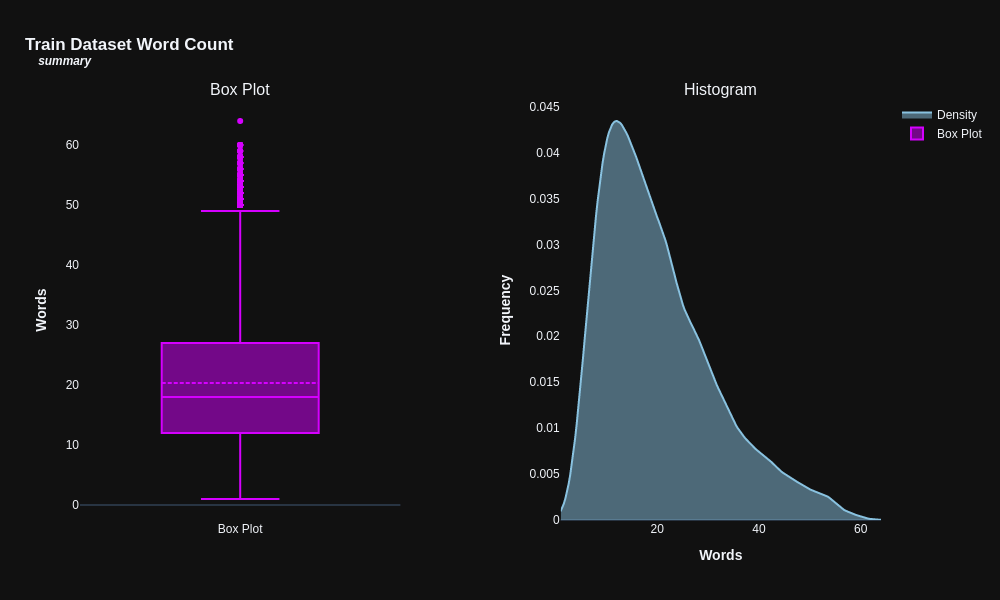

In [82]:
df_text_lenght = pd.DataFrame() # Creating an empty dataframe
for feat in categorical_features: # Iterating through features --> Dialogue & Summary
    df_text_lenght[feat] = train[feat].apply(lambda x: len(str(x).split())) #  Counting words for each feature

# Plotting histogram-boxplot
histogram_boxplot(df_text_lenght,'#89c2e0', '#d500ff', 600, 1000, True, 'Train Dataset')

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">On average, dialogues consist of about 94 words. We do have some outliers with very extensive texts, going way over 300 words per dialogue.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Summaries are naturally shorter texts, consisting of about 20 words on average, although we also have some outliers with extensive summaries.</p>

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">We can also use scikit-learn's <code>TfidfVectorizer</code> to extract more info on the dialogues and summaries available. This function will give us a dataframe with the top $n$ most frequent terms in the corpus, which we select by using the <code>max_features</code> parameter.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">In this dataframe, each column represents the $n$ most frequent terms in the overall corpus, while each row represents one entry in the original dataframe, such as <code>train</code>. For each term in each entry, we will see the TF-IDF score associated with it, which quantifies the relevance of a term in a given dialogue — or summary — relative to its frequency across all other dialogues — or summaries.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">We will also use the <code>ngram_range</code> parameter to select the most frequent words (unigrams), the most frequent sequence of two words (bigrams), and the most frequent sequence of three words (trigrams). The <code>stop_words = 'english'</code> parameter will help us filter out common stop-words of the English language, which are words that do not add up much to the overall context, such as <i>"and"</i>, <i>"of"</i>, etc.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">After measuring the most frequent terms, I will plot a heatmap displaying the correlations between these terms. This may help us understand how frequently they are used together in dialogues. For instance, how frequent is the occurrence of the word <i>"will"</i> when the word <i>"we"</i> is present?</p>

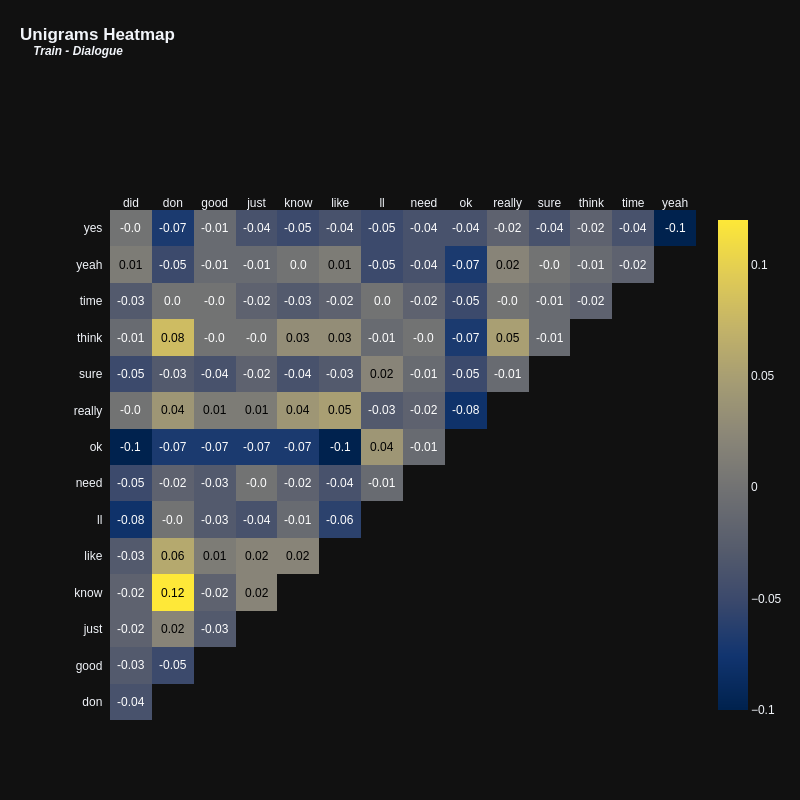

In [84]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(train['dialogue'])
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Train - Dialogue', 800, 800, 12)

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">You can see that the correlations between these terms are neither strongly positive nor strongly negative. The most positively correlated terms are <i>"don"</i> and <i>"know"</i>, at 0.12. It is relevant to observe that the <code>TfidfVectorizer</code> function performs some changes to the text, such as removing contractions, which explains why the word <i>don't</i> appears without its apostrophe <i>'t</i>.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">It is also interesting to notice a negative correlation — although still not extremely significant — between the terms <i>"yes"</i> and <i>"yeah"</i>. Maybe this happens because it would be redundant to include both in the same dialogue, or perhaps the data captures a tendency of individuals to use <i>"yeah"</i> instead of <i>"yes"</i> during conversations. These are some hypotheses we can consider when analyzing this type of heatmaps.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Let's perform the same analysis to the summaries.</p>

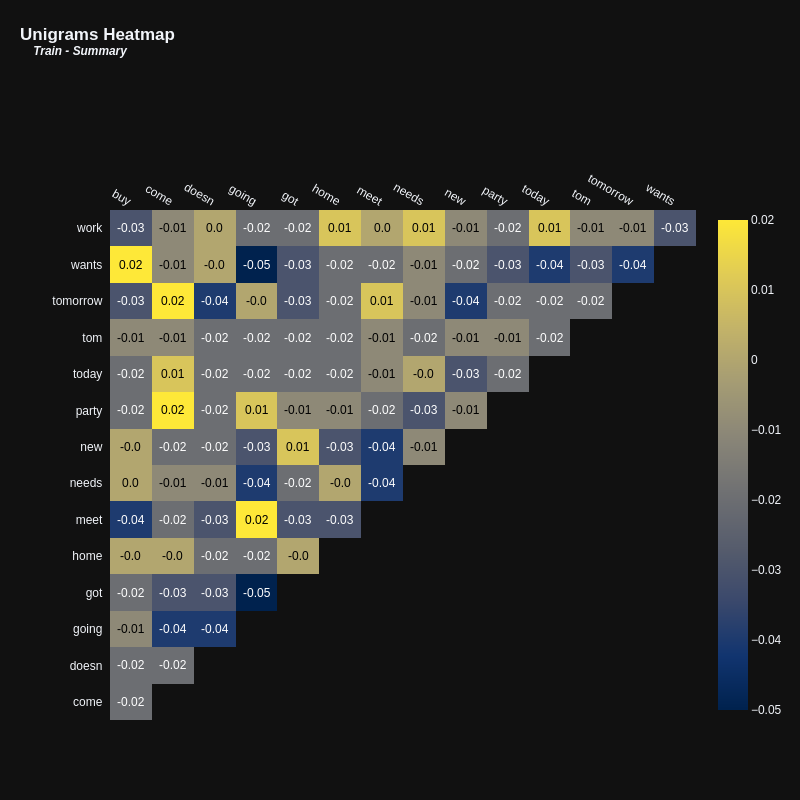

In [85]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(train['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Train - Summary', 800, 800, 12)

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">The correlations of terms in summaries seem to be more pronounced than those in dialogues, even though these correlations are still not strong. This suggests that summaries may convey relevant information more succinctly than full dialogues, which is exactly the idea behind a summary.</p>

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">We have positively correlated pairs such as <i>"going"</i> and <i>"meet"</i>, <i>"come"</i> and <i>"party"</i>, as well as <i>"buy"</i> and <i>"wants"</i>. It makes perfect sense to see these unigrams appearing together across texts.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Conversely, it's reasonable for negatively correlated pairs <b>not</b> to co-occur frequently in texts, such as <i>"going"</i> and <i>"wants"</i>, and <i>"going"</i> and <i>"got"</i>.</p>

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Let's now analyze bigrams across dialogues and summaries.</p>

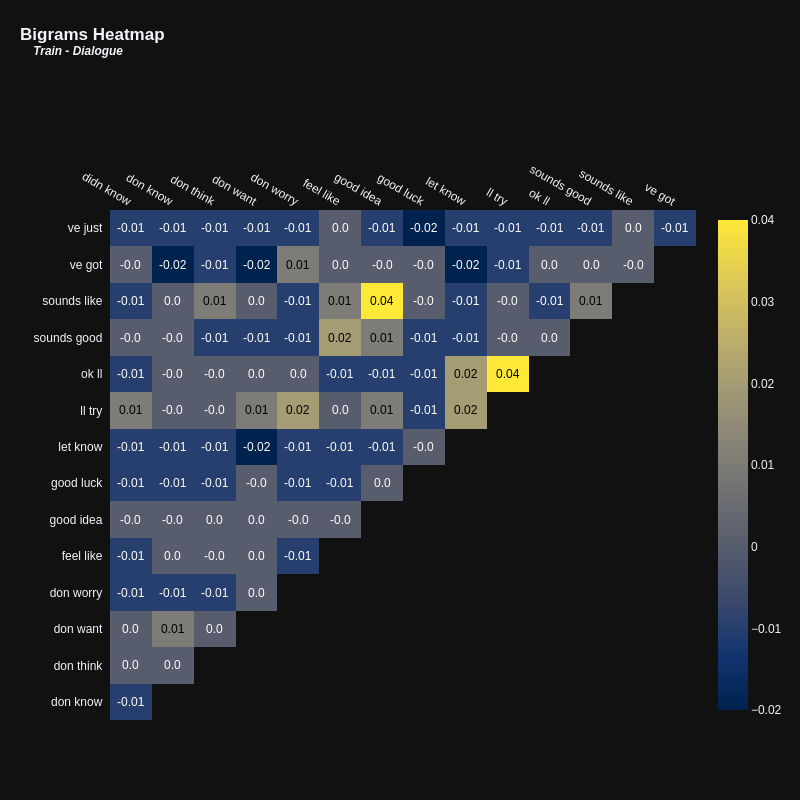

In [86]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(train['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Train - Dialogue', 800, 800, 12)

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Once more, the correlations are not extremely strong. Still, we can see some pairs that seem reasonable to be together, such as <i>"good idea"</i> and <i>"sounds like"</i>.</p>

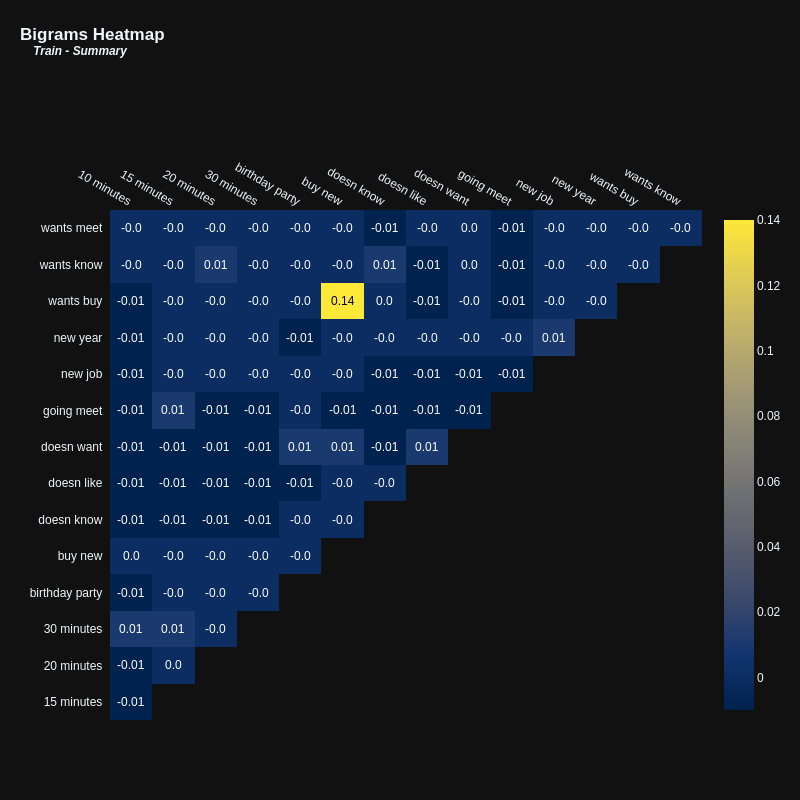

In [87]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(train['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Train - Summary', 800, 800, 12)

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">We have only one correlation between the pairs <i>"wants buy"</i> and <i>"buy new"</i>. The other terms do not appear to have any kind of correlation at all.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">It is interesting to see the tendency of the summaries to contain information on minutes, which does not seem to be present in the dialogues. We can even investigate further this relationship by querying some summaries where the bigram <i>15 minutes</i> appears in the summary.</p>

In [91]:
# Filtering dataset to see those containing the term '15 minutes' in the summary
filtered_train = train[train['summary'].str.contains('15 minutes', case=False, na=False)]
filtered_train.head()

,id,dialogue,summary
136,13827893,"Kate: I'm here <file_other>\r\nKate: there was no place in Red Lion\r\nSteven: hey! but it's quite far away\r\nKate: c'mon it's just 10 min by bike!\r\nSteven: yes, but I'm not by bike\r\nKate: car?\r\nSteven: nope\r\nSteven: by foot :P :P \r\nSteven: anyway google maps says 15 min and I'm there:D\r\nKate: ok, w8in ^^",Kate will meet with Steven in 15 minutes.
428,13811484-1,"Jenny: Let's go out to eat.\r\nLucy: That sounds like fun.\r\nJenny: Where do you wanna go?\r\nLucy: Let me think a minute.\r\nJenny: I feel like Chinese.\r\nLucy: That sounds yummy.\r\nJenny: I know a good Chinese restaurant.\r\nLucy: How far away is it?\r\nJenny: It's only 10 minutes from my place.\r\nLucy: Do we have to book a table?\r\nJenny: Oh, no. We can walk right in.\r\nLucy: Cool. Will be in 15 minute. I'm really hungry!",Jenny and Lucy are going to a Chinese restaurant to eat. They do not need to book a table. Lucy will be at Jenny's in 15 minutes.
570,13818296,Danielle: hey where RU?\r\nJuan: I told u I'd be late!\r\nDanielle: but it's been almost 45 mins!\r\nDanielle: <file_gif>\r\nJuan: I'll be there in 15 minutes\r\nJuan: <file_gif>,Juan is almost 45 minutes late. He'll be there in 15 minutes.
1213,13682296-1,"John: I know you will be outraged but I like to provoke you :P\r\nTyre: What is it?\r\nJohn: I talked to our neighbour today and I am really starting to think that religious people are just stupid.\r\nTyre: Gosh. You know it's a stupid claim.\r\nJohn: I know that there are some clever, religious individuals. But statistically religious people are stupid.\r\nTyre: It's not true. There are stupid religious people and clever ones, just like atheists.\r\nJohn: But most of academics are not religious.\r\nTyre: How do you know it?\r\nJohn: Experience but also some data I've seen.\r\nTyre: It's just not true.\r\nJohn: They are mostly people believing in things that have nothing to do with logic or reason: miracles, ghosts, witchcraft, just as our neighbour.\r\nTyre: I think it's only one part of them. There are theologians, people who actually know a lot about philosophy, logic etc.\r\nJohn: Yes, there are also people doing ""scientifically"" tarot, horoscopes and astrology.\r\nTyre: You ca...",John and Tyre's neighbour stopped John in the staircase and talked about some miracles for 15 minutes. John thinks that religious people are stupid. Tyre disagrees with this generalization.
1812,13820691,"Madge: are you alive? xD\r\nDorothy: i'm still drunk\r\nMadge: xDDDDDDDD jeeez\r\nFelicia: I don't know...how much did i drink?\r\nMadge: like 10 rounds\r\nFelicia: SHIT \r\nFelicia: you gotta be kidding me ahahaha xDDDDDDDDDDDDDDDDDD\r\nDorothy: of course she is\r\nDorothy: it was at least 15\r\nFelicia: ;________________;\r\nFelicia: was nice to meet you girls...shame on me as always\r\nDorothy: oh stop talking\r\nDorothy: just live the moment B-)\r\nFelicia: how am i supossed to live the moment if i don't remember the half o the night XD\r\nDorothy: well it happens :p \r\nMadge: we gotta repeat it, i had a lot of fun :D\r\nDorothy: i'm in. in 15min?\r\nFelicia: you're crazy ;-;",Dorothy is still intoxicated after at least 15 rounds of drink yesterday and can't remember much of what happened. She would like to meet her friends for a drink again in 15 minutes.


<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">The last row gives us an idea of why we see so many terms related to minutes in summaries, but not in dialogues. In dialogues, people may write "15min" together or even other forms of it, such as "15m", whereas the summaries give us a patternized description, making it natural to be more prominent than other forms to describe time.</p>

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Let's now visualize the trigrams.</p>

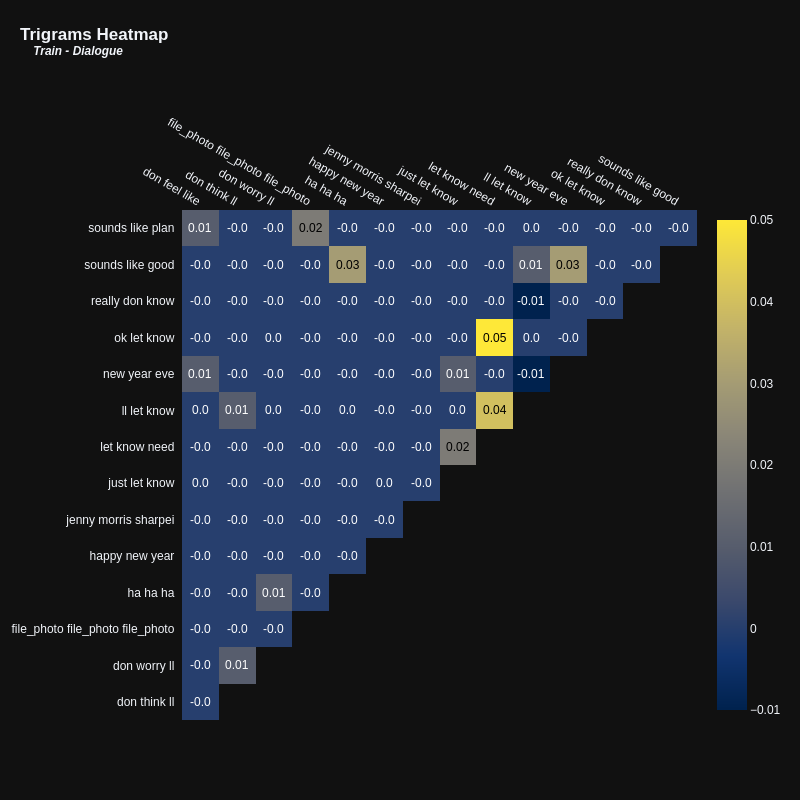

In [88]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(train['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Train - Dialogue', 800, 800, 12)

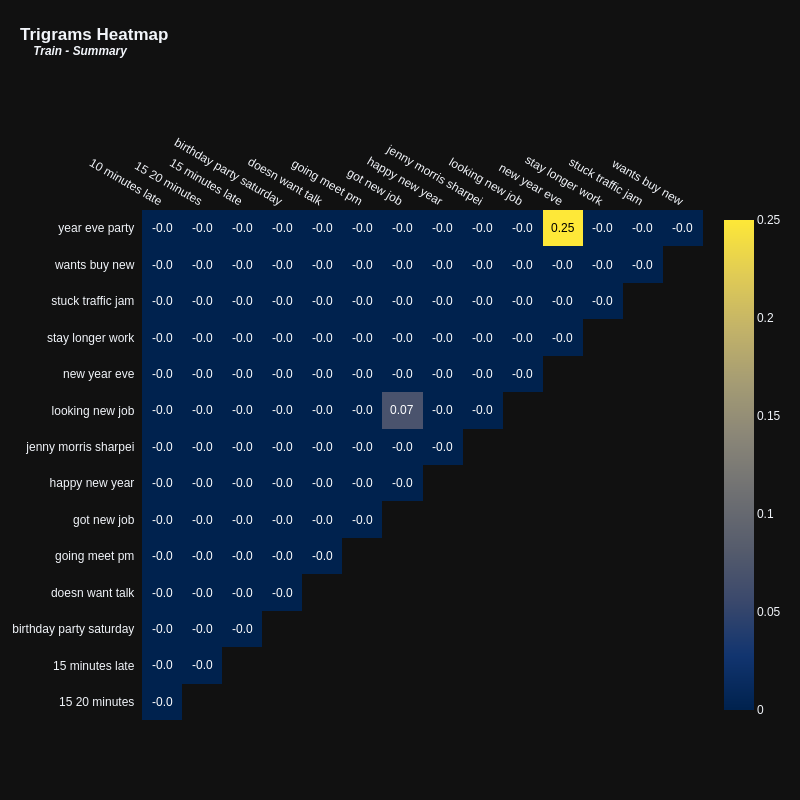

In [89]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(train['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Train - Summary', 800, 800, 12)

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Once more, we can see that the terms are not strongly correlated. But still, it is possible to see pairs that seem logical to appear together in the corpus.</p>

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">I will now perform the exact same analysis on the <code>test</code> and <code>val</code> datasets. We can expect the same behavior as the ones seen during the analysis of the training set, which is why I will refrain from commenting on the following plots to avoid redundancy. However, if something different appears, we will surely investigate further.</p>

<div id = 'test'
     style="font-family: Calibri, serif; text-align: left;">
    <hr style="border: none;
               width: 100%;
               margin-top: 62px;
               margin-bottom: auto;
               margin-left: 0;">
    <div style="font-size: 30px; letter-spacing: 2.25px;color: #02011a;"><b>Test Dataset</b></div>
</div>

In [92]:
# Extracting info on the test dataset
describe_df(test)


DataFrame shape: (819, 3)

819 samples

3 attributes

Missing Data: 
id          0
dialogue    0
summary     0
dtype: int64

Duplicates: 0

Data Types: 
id          object
dialogue    object
summary     object
dtype: object

Categorical Features: 
id, dialogue, summary

Continuous Features: 
None

Binary Features: 
None

DataFrame Head: 



,id,dialogue,summary
0,13862856,"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye",Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.
1,13729565,Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric: I know! And shows how Americans see Russian ;)\r\nRob: And it's really funny!\r\nEric: I know! I especially like the train part!\r\nRob: Hahaha! No one talks to the machine like that!\r\nEric: Is this his only stand-up?\r\nRob: Idk. I'll check.\r\nEric: Sure.\r\nRob: Turns out no! There are some of his stand-ups on youtube.\r\nEric: Gr8! I'll watch them now!\r\nRob: Me too!\r\nEric: MACHINE!\r\nRob: MACHINE!\r\nEric: TTYL?\r\nRob: Sure :),Eric and Rob are going to watch a stand-up on youtube.
2,13680171,"Lenny: Babe, can you help me with something?\r\nBob: Sure, what's up?\r\nLenny: Which one should I pick?\r\nBob: Send me photos\r\nLenny: <file_photo>\r\nLenny: <file_photo>\r\nLenny: <file_photo>\r\nBob: I like the first ones best\r\nLenny: But I already have purple trousers. Does it make sense to have two pairs?\r\nBob: I have four black pairs :D :D\r\nLenny: yeah, but shouldn't I pick a different color?\r\nBob: what matters is what you'll give you the most outfit options\r\nLenny: So I guess I'll buy the first or the third pair then\r\nBob: Pick the best quality then\r\nLenny: ur right, thx\r\nBob: no prob :)",Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are of best quality.
3,13729438,"Will: hey babe, what do you want for dinner tonight?\r\nEmma: gah, don't even worry about it tonight\r\nWill: what do you mean? everything ok?\r\nEmma: not really, but it's ok, don't worry about cooking though, I'm not hungry\r\nWill: Well what time will you be home?\r\nEmma: soon, hopefully\r\nWill: you sure? Maybe you want me to pick you up?\r\nEmma: no no it's alright. I'll be home soon, i'll tell you when I get home. \r\nWill: Alright, love you. \r\nEmma: love you too.",Emma will be home soon and she will let Will know.
4,13828600,"Ollie: Hi , are you in Warsaw\r\nJane: yes, just back! Btw are you free for diner the 19th?\r\nOllie: nope!\r\nJane: and the 18th?\r\nOllie: nope, we have this party and you must be there, remember?\r\nJane: oh right! i lost my calendar.. thanks for reminding me\r\nOllie: we have lunch this week?\r\nJane: with pleasure!\r\nOllie: friday?\r\nJane: ok\r\nJane: what do you mean "" we don't have any more whisky!"" lol..\r\nOllie: what!!!\r\nJane: you just call me and the all thing i heard was that sentence about whisky... what's wrong with you?\r\nOllie: oh oh... very strange! i have to be carefull may be there is some spy in my mobile! lol\r\nJane: dont' worry, we'll check on friday.\r\nOllie: don't forget to bring some sun with you\r\nJane: I can't wait to be in Morocco..\r\nOllie: enjoy and see you friday\r\nJane: sorry Ollie, i'm very busy, i won't have time for lunch tomorrow, but may be at 6pm after my courses?this trip to Morocco was so nice, but time consuming!\r\nOllie: ok fo...",Jane is in Warsaw. Ollie and Jane has a party. Jane lost her calendar. They will get a lunch this week on Friday. Ollie accidentally called Jane and talked about whisky. Jane cancels lunch. They'll meet for a tea at 6 pm.



DataFrame Tail: 



,id,dialogue,summary
814,13611902-1,"Alex: Were you able to attend Friday night's basketball game?\r\nBenjamin: I was unable to make it.\r\nAlex: You should have been there. It was intense.\r\nBenjamin: Is that right. Who ended up winning?\r\nAlex: Our team was victorious.\r\nBenjamin: I wish I was free that night. I'm kind of mad that I didn't go.\r\nAlex: It was a great game. Everything alright tough?\r\nBenjamin: Yeah man thanks for asking, it's just that my mom is sick and I am taking care of her.\r\nAlex: Oh sorry to hear that. Hope she makes a fast recovery 💪\r\nBenjamin: She will, she just has a nasty flu but she will be alright :D\r\nAlex: Glad to hear that!\r\nBenjamin: What was the score at the end of the game?\r\nAlex: Our team won 101-98.\r\nBenjamin: Sounds like it was a close game then.\r\nAlex: That's the reason it was such a great game.\r\nBenjamin: I'll go to the next one for sure.\r\nAlex: It's next weekend so you better put on your calendar ahaha\r\nBenjamin: ahaha I will I will. Talk to you later!\...",Benjamin didn't come to see a basketball game on Friday's night. The team supported by Alex won 101-98. Benjamin's mom has a flu and he's looking after her. Benjamin declares to attend the next basketball match.
815,13820989,Jamilla: remember that the audition starts at 7.30 P.M.\r\nKiki: which station?\r\nJamilla: Antena 3\r\nYoyo: roger that,The audition starts at 7.30 P.M. in Antena 3.
816,13717193,"Marta: <file_gif>\r\nMarta: Sorry girls, I clicked something by accident :D\r\nAgnieszka: No problem :p\r\nWeronika: Hahaha\r\nAgnieszka: Good thing you didn't send something from your gallery ;)","Marta sent a file accidentally,"
817,13829115,"Cora: Have you heard how much fuss British media made about meet and greet with James Charles in Birmingham?\r\nEllie: no...! what happened?\r\nCora: Well, there was a meet and greet with James Charles in one of the malls in Birmingham and about 8000 fans showed up for it.\r\nCora: It cause a gridlock around the mall and - of course - British media had to make some (quite negative) comments on it.\r\nEllie: they came for sister James?! >:(\r\nEllie: i sister snapped!! :p :D\r\nCora: Haha :D\r\nCora: You shouldn't watch so much youtube, you're getting weirder and weirder. :d\r\nEllie: sister shut up :P so, what did they say?\r\nCora: ;) :* ""Daily Mail"" was surprised that a meet and greet with a ""virtually unknown"" youtuber gathered 8000 people. :p\r\nCora: A host from LBC tried to find an answer to an unanswerable question: ""Who is James Charles?"". Eventually James called him and introduced himself. On air. :D\r\nEllie: there's something called google lol\r\nCora: Right? :p\r\nCora:...",There was a meet-and-greet with James Charles in Birmingham which gathered 8000 people.
818,13818810,"Rachel: <file_other>\r\nRachel: Top 50 Best Films of 2018\r\nRachel: :)\r\nJanice: Omg, I've watched almost all 50... xDD\r\nSpencer: Hahah, Deadpool 2 also??\r\nJanice: Yep\r\nSpencer: Really??\r\nJanice: My bf forced me to watch it xD\r\nRachel: Hahah\r\nJanice: It wasn't that bad\r\nJanice: I thought it'd be worse\r\nRachel: And Avengers? :D\r\nJanice: 2 times\r\nRachel: Omg\r\nJanice: xP\r\nRachel: You are the best gf in the world\r\nRachel: Your bf should appreciate that ;-)\r\nJanice: He does\r\nJanice: x)","Rachel sends a list of Top 50 films of 2018. Janice watched almost half of them, Deadpool 2 and Avengers included."


In [93]:
# Removing 'Id' from categorical features list
categorical_features.remove('id')

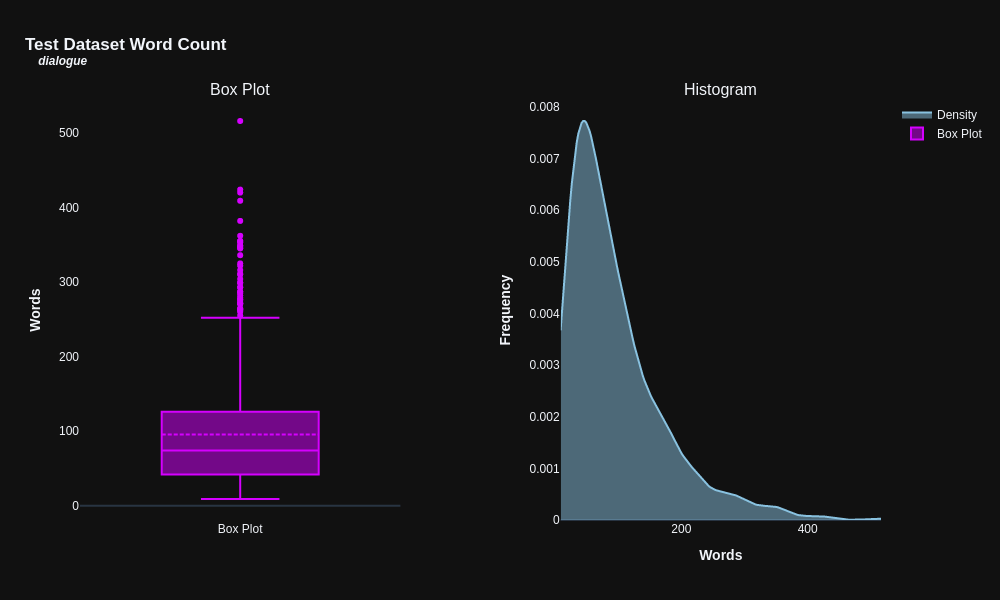

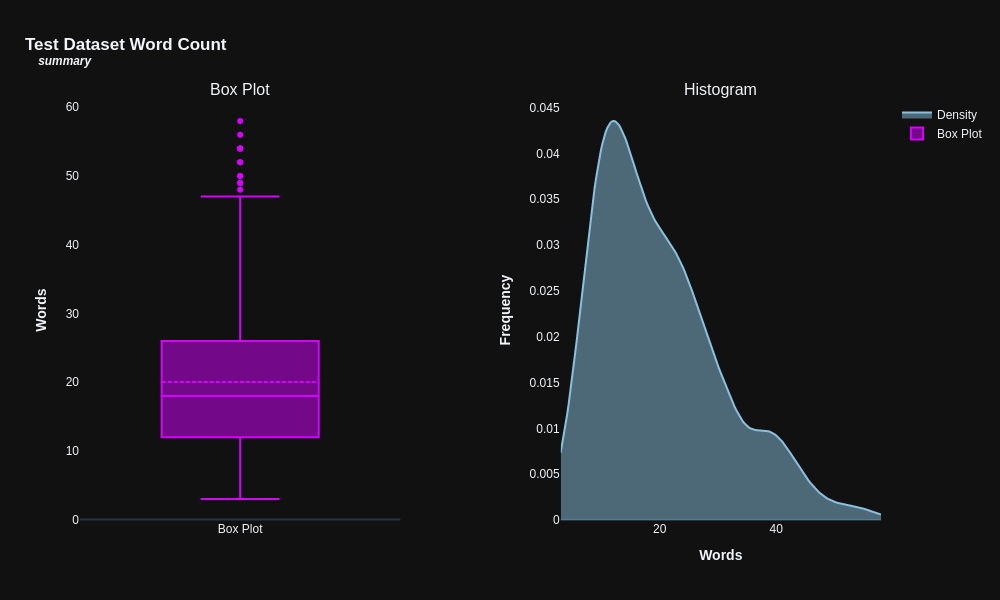

In [94]:
df_text_lenght = pd.DataFrame()
for feat in categorical_features:
    df_text_lenght[feat] = test[feat].apply(lambda x: len(str(x).split()))

histogram_boxplot(df_text_lenght,'#89c2e0', '#d500ff', 600, 1000, True, 'Test Dataset')

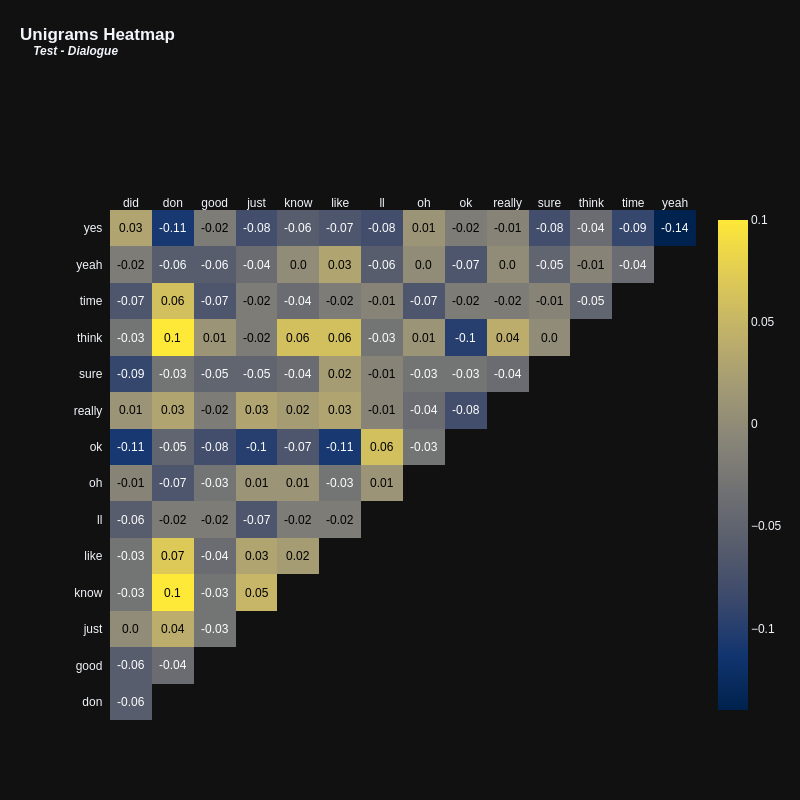

In [96]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(test['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Test - Dialogue', 800, 800, 12)

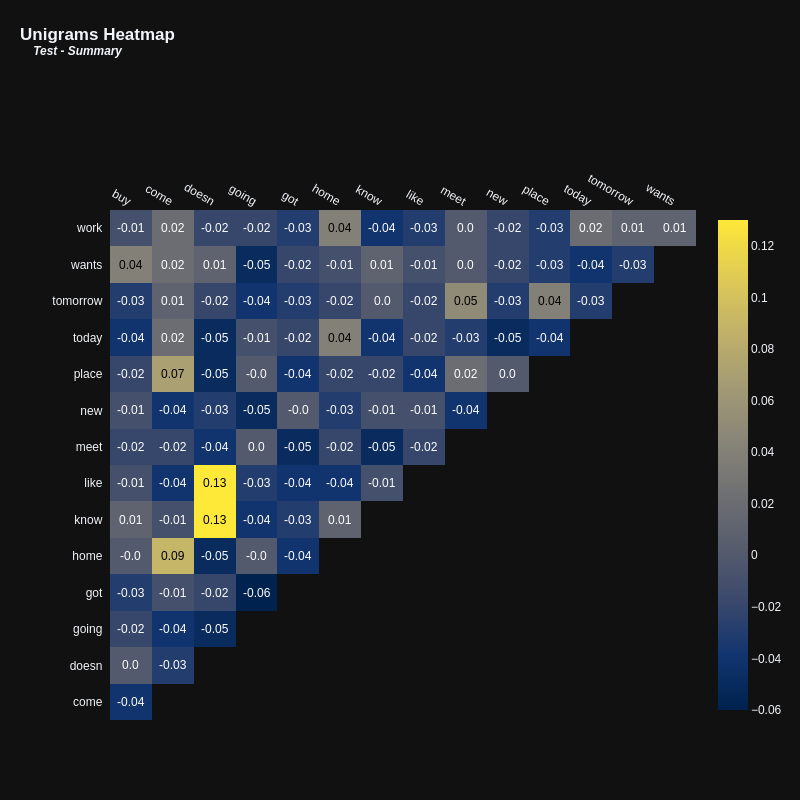

In [97]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(test['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Test - Summary', 800, 800, 12)

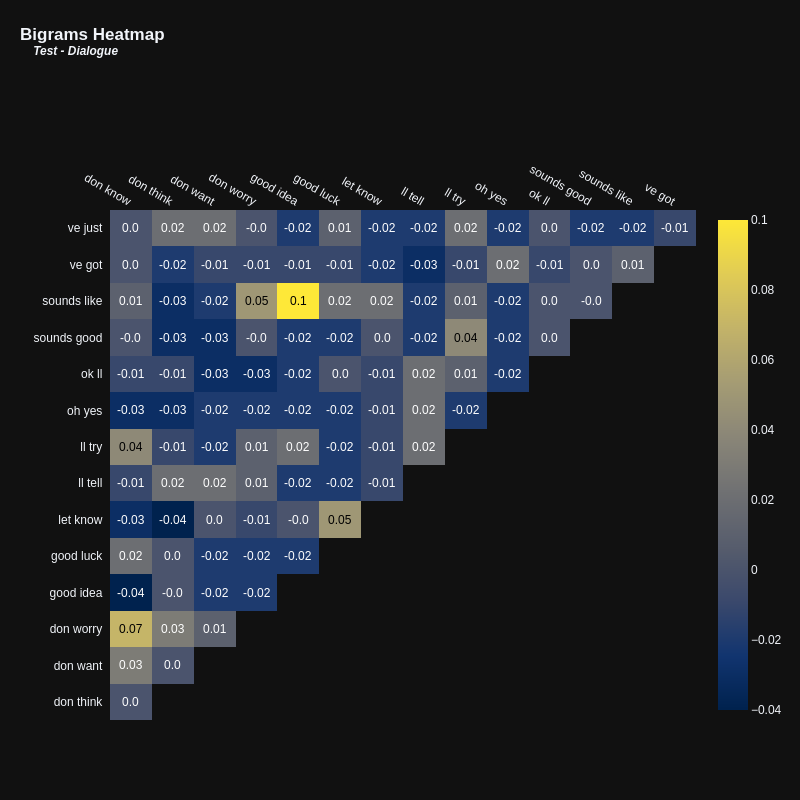

In [98]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(test['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Test - Dialogue', 800, 800, 12)

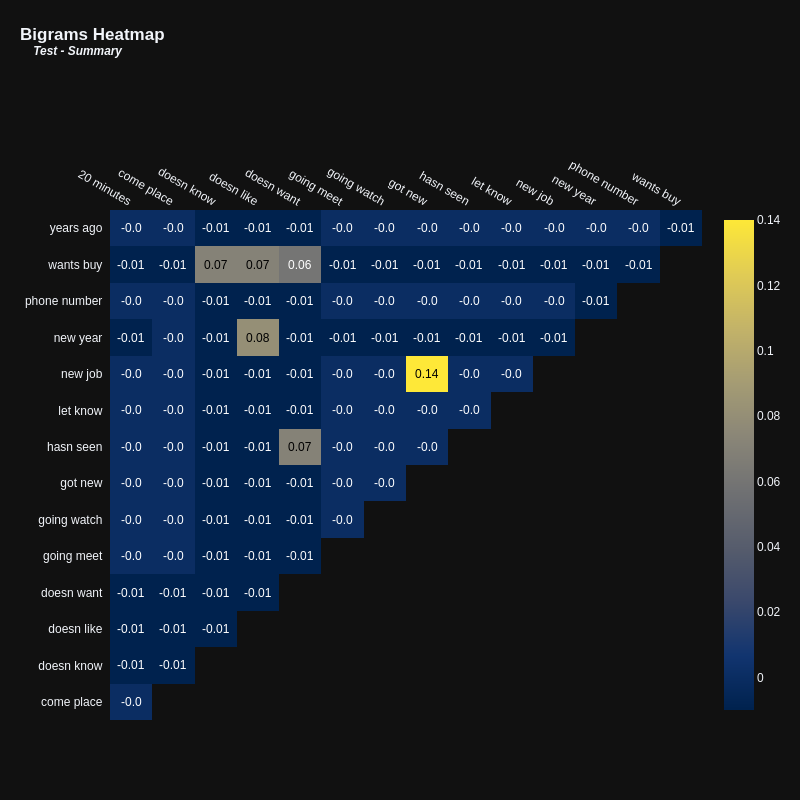

In [99]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(test['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Test - Summary', 800, 800, 12)

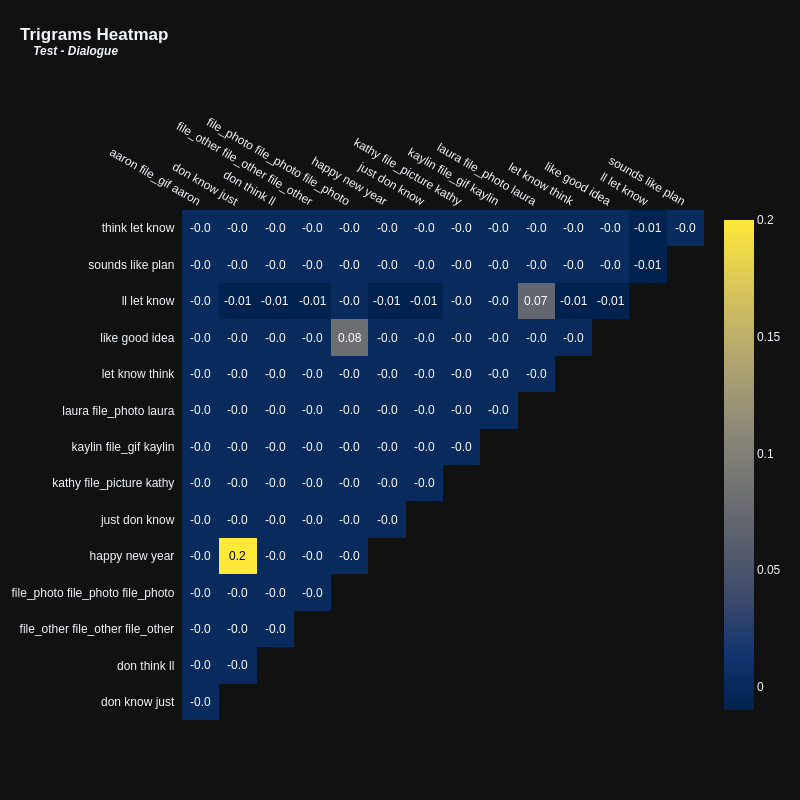

In [100]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(test['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Test - Dialogue', 800, 800, 12)

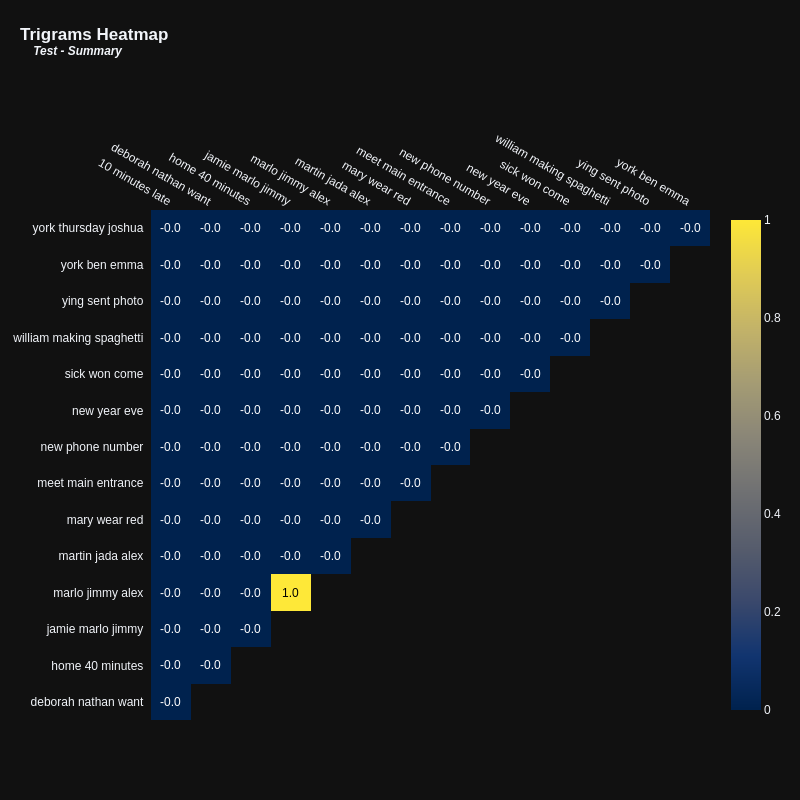

In [101]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(test['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Test - Summary', 800, 800, 12)

<div id = 'val'
     style="font-family: Calibri, serif; text-align: left;">
    <hr style="border: none;
               width: 100%;
               margin-top: 62px;
               margin-bottom: auto;
               margin-left: 0;">
    <div style="font-size: 35px; letter-spacing: 2.25px;color: #02011a;"><b>Validation Dataset</b></div>
</div>

In [102]:
# Extracting info on the val dataset
describe_df(val)


DataFrame shape: (818, 3)

818 samples

3 attributes

Missing Data: 
id          0
dialogue    0
summary     0
dtype: int64

Duplicates: 0

Data Types: 
id          object
dialogue    object
summary     object
dtype: object

Categorical Features: 
id, dialogue, summary

Continuous Features: 
None

Binary Features: 
None

DataFrame Head: 



,id,dialogue,summary
0,13817023,"A: Hi Tom, are you busy tomorrow’s afternoon?\r\nB: I’m pretty sure I am. What’s up?\r\nA: Can you go with me to the animal shelter?.\r\nB: What do you want to do?\r\nA: I want to get a puppy for my son.\r\nB: That will make him so happy.\r\nA: Yeah, we’ve discussed it many times. I think he’s ready now.\r\nB: That’s good. Raising a dog is a tough issue. Like having a baby ;-) \r\nA: I'll get him one of those little dogs.\r\nB: One that won't grow up too big;-)\r\nA: And eat too much;-))\r\nB: Do you know which one he would like?\r\nA: Oh, yes, I took him there last Monday. He showed me one that he really liked.\r\nB: I bet you had to drag him away.\r\nA: He wanted to take it home right away ;-).\r\nB: I wonder what he'll name it.\r\nA: He said he’d name it after his dead hamster – Lemmy - he's a great Motorhead fan :-)))",A will go to the animal shelter tomorrow to get a puppy for her son. They already visited the shelter last Monday and the son chose the puppy.
1,13716628,"Emma: I’ve just fallen in love with this advent calendar! Awesome! I wanna one for my kids!\r\nRob: I used to get one every year as a child! Loved them! \r\nEmma: Yeah, i remember! they were filled with chocolates!\r\nLauren: they are different these days! much more sophisticated! Haha!\r\nRob: yeah, they can be fabric/ wooden, shop bought/ homemade, filled with various stuff\r\nEmma: what do you fit inside?\r\nLauren: small toys, Christmas decorations, creative stuff, hair bands & clips, stickers, pencils & rubbers, small puzzles, sweets\r\nEmma: WOW! That’s brill! X\r\nLauren: i add one more very special thing as well- little notes asking my children to do something nice for someone else\r\nRob: i like that! My sister adds notes asking her kids questions about christmas such as What did the 3 wise men bring? etc\r\nLauren: i reckon it prepares them for Christmas \r\nEmma: and makes it more about traditions and being kind to other people\r\nLauren: my children get very excited eve...","Emma and Rob love the advent calendar. Lauren fits inside calendar various items, for instance, small toys and Christmas decorations. Her children are excited whenever they get the calendar."
2,13829420,Jackie: Madison is pregnant\r\nJackie: but she doesn't wanna talk about it\r\nIggy: why\r\nJackie: I don't know why because she doesn't wanna talk about it\r\nIggy: ok\r\nJackie: I wanted to prepare you for it because people get super excited and ask lots of questions\r\nJackie: and she looked way more anxious than excited\r\nIggy: she's probably worrying about it\r\nIggy: she's taking every commitment really seriously\r\nJackie: it could be money problems or relationship problems\r\nIggy: or maybe she wants an abortion\r\nJackie: it could be all of the above\r\nIggy: but you know what?\r\nIggy: once my friend was pregnant and I couldn't bring myself to be happy about it\r\nJackie: why?\r\nIggy: I felt they were immature and I couldn't picture this couple as parents\r\nJackie: I felt similar way on Patricia's wedding\r\nIggy: Patricia Stevens?\r\nJackie: yes\r\nIggy: so we're talking about the same person\r\nJackie: what a coincidence\r\nJackie: so she's pregnant?\r\nIggy: she thou...,Madison is pregnant but she doesn't want to talk about it. Patricia Stevens got married and she thought she was pregnant.
3,13819648,"Marla: <file_photo>\r\nMarla: look what I found under my bed\r\nKiki: lol\r\nTamara: is that someone's underwear?\r\nMarla: it certainly isn't mine, my ass is big but it isn't huge\r\nKiki: it looks like male underwear\r\nTamara: not necessarily, maybe some butch had fun in your room while you were gone\r\nMarla: ok but how can you leave your underwear after hooking up? wtf is wrong with people\r\nKiki: she or he could be too wasted to notice\r\nTamara: or maybe someone put their pants there to piss you off\r\nMarla: that makes no sense\r\nMarla: it's so fucking childish\r\nKiki: if it's childish then it must have been your sister


DataFrame Tail: 



,id,dialogue,summary
813,13829423,"Carla: I've got it...\r\nDiego: what?\r\nCarla: my date for graduation. Hope you're coming\r\nDiego: if you tell me when...\r\nCarla: oups sorry. June 4th\r\nDiego: we've got time.\r\nCarla: of course, but you have to book your plane\r\nDiego: i still don't know, and it's quite expensive\r\nCarla: that's why you have to book it right now. Please tell me you'll come\r\nDiego: i'd love to for sure\r\nCarla: come, come, please\r\nDiego: ok, i'll have a look and tell you.\r\nCarla: you could stay home for the week, my roommate won't be there.\r\nDiego: didn't you tell me your parents would come?\r\nCarla: yes they will, but they've got friends they could stay with.\r\nDiego: what was the company you flew with when you came last month?\r\nCarla: aeromexico was the cheapest at that time, but check with delta\r\nDiego: i think there is some flight comparison websites and also some apps.\r\nCarla: i only know the canadian one\r\nDiego: don't worry i'll find out \r\nCarla: ok ! i've to l...",Carla's date for graduation is on June 4th. Diego will try to come then.
814,13727710,"Gita: Hello, this is Beti's Mum Gita, I wanted to ask if you were going on the school trip?\r\nBev: Hi Gita, yes, Milo wants me to come, he's a bit nervous going away from home or school still.\r\nGita: Yes, Beti is the same, they are still only 4 or 5 after all.\r\nBev: I know, still so young! It will help the teachers and TAs anyway, they have a lot to cope with!\r\nGita: I know, I could never do their job! I work part time as a music teacher, going round schools.\r\nBev: Oh really? I am in Marks, part time too, love it there! \r\nGita: Yes, it really helps to do some sort of work doesn't it! I could never manage full time, though.\r\nBev: Oh, I know, Gita. My sister's in management and she doesn't see her kids from 6.30am to 6.30pm every day! She is a high flier, but she does miss them. She does do lots with them on the weekend, though.\r\nGita: Yes, but children need time to just be at home and play or just be with family, not galavanting around all the time!\r\nBev: I agree 10...",Bev is going on the school trip with her son. Gita is going on the school trip with her daughter. Bev's sister rarely sees her children during the week because of her job. Gita has a few pets at home. The mothers with their children have to be at school at 7.45 to not miss the bus.
815,13829261,"Julia: Greg just texted me\r\nRobert: ugh, delete him already\r\nJulia: He's saying he's sorry\r\nRobert: damn girl, delete the bastard\r\nJulia: it's not that simple, you know it\r\nRobert: No Julia, it is pretty simple\r\nRobert: go and delete him\r\nJulia: But he apologised, ok? He's never done it before\r\nRobert: srsly?\r\nRobert: do I need to remind you he cheated on you?\r\nRobert: Julia I'm not going through this again with you\r\nJulia: People change, I do believe it, maybe he changed. He apologised\r\nRobert: and that's it? That' ok? how's different from two other times?\r\nJulia: i told you - he apologised! he's sorry, he wants to meet\r\nRobert: don't, honey, really. We've been through this\r\nJulia: I know, but it's not easy. I think I love him\r\nRobert: i know you do, but you need to be strong. do you want to come over?\r\nJulia: no, thank you love, but i have to get up early tomorrow\r\nRobert: ok, you should go to sleep then\r\nJulia: what about Greg?\r\nRobert: do...",Greg cheated on Julia. He apologises to her. Robert tells Julia not to meet Greg.
816,13680226,"Marry: I broke my nail ;(\r\nTina: oh, no!\r\nMarry: u know I have that party tomorrow!!!\r\nTina: I know, let me think...\r\nTina: I got it!. My sister friend is a cosmetitian, maybe she 'll help\r\nMarry: anyone will be good, I'm desperate!\r\nTina: I'll call her and let u know, ok?\r\nMarry: ok, I'll wait, but hurry!",Marry broke her nail and has a party tomorrow. Tina will call a cosmetician that she knows and let Marry know if she can help.
817,13862383,"Paige: I asked them t

In [103]:
# Removing 'Id' from categorical features list
categorical_features.remove('id')

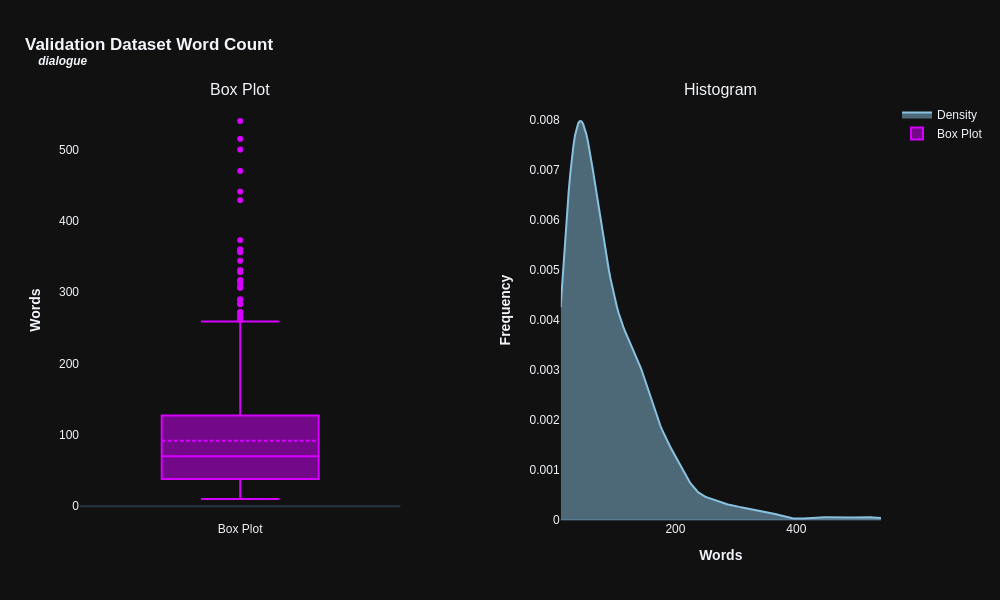

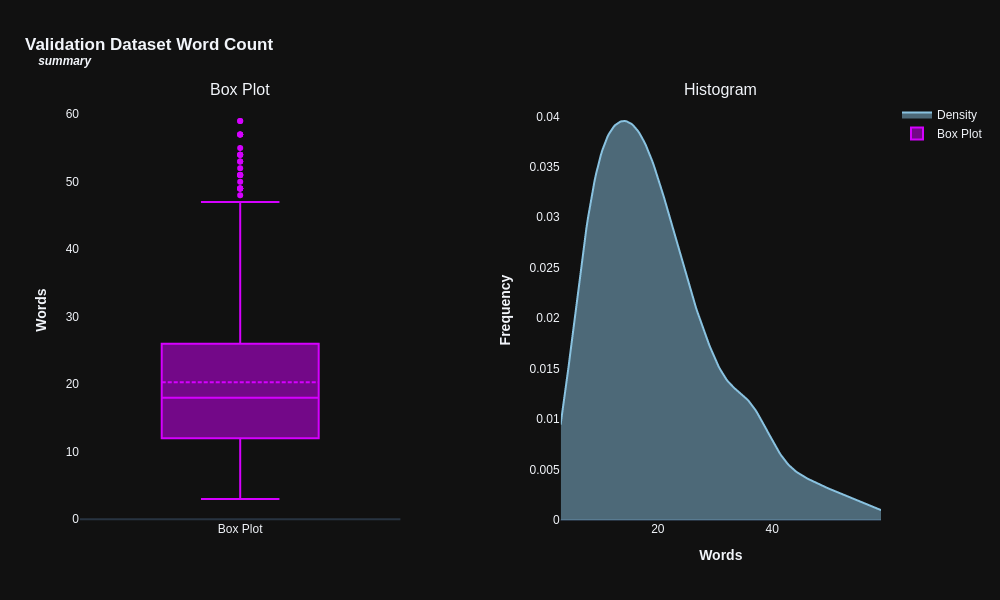

In [104]:
df_text_lenght = pd.DataFrame()
for feat in categorical_features:
    df_text_lenght[feat] = val[feat].apply(lambda x: len(str(x).split()))

histogram_boxplot(df_text_lenght,'#89c2e0', '#d500ff', 600, 1000, True, 'Validation Dataset')

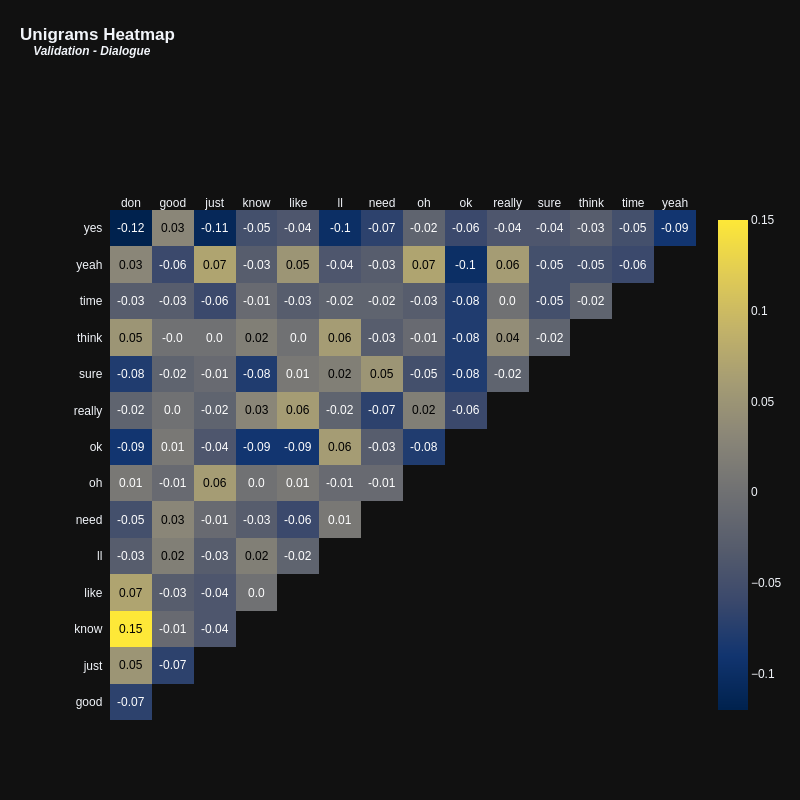

In [105]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(val['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Validation - Dialogue', 800, 800, 12)

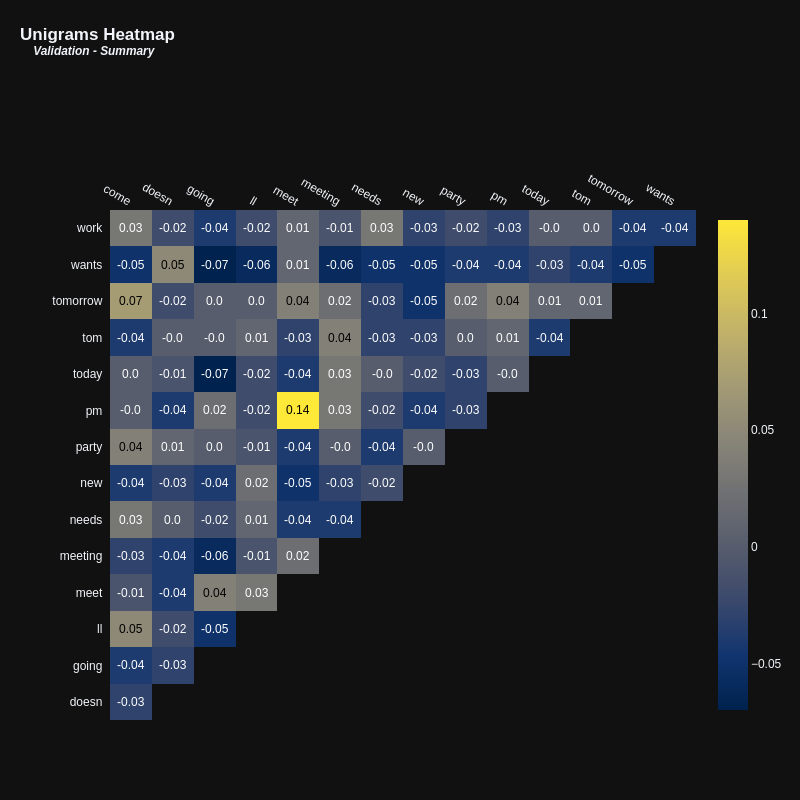

In [106]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(val['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Validation - Summary', 800, 800, 12)

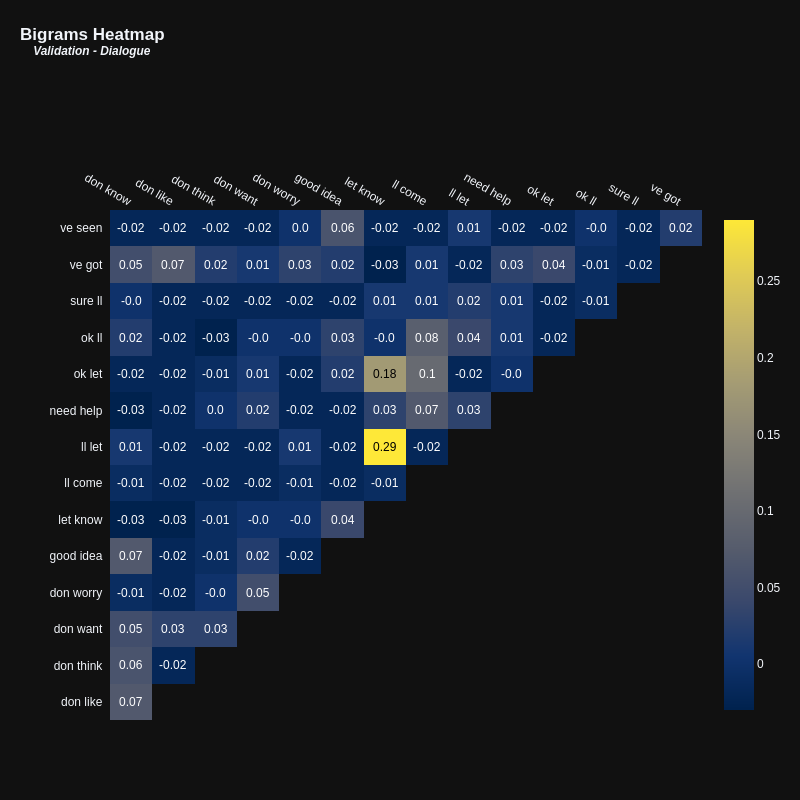

In [107]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(val['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Validation - Dialogue', 800, 800, 12)

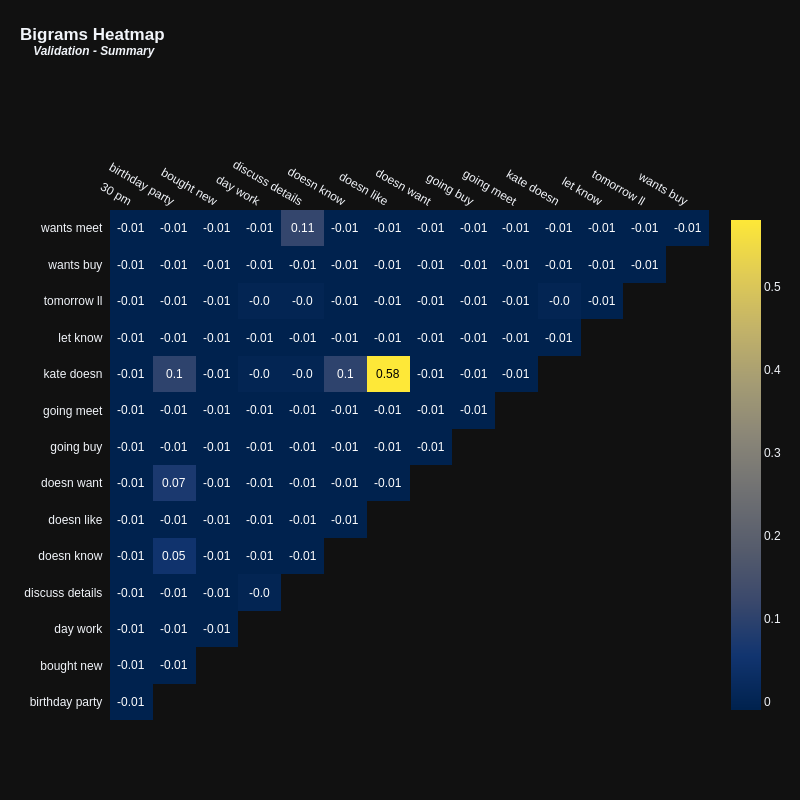

In [108]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(val['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Validation - Summary', 800, 800, 12)

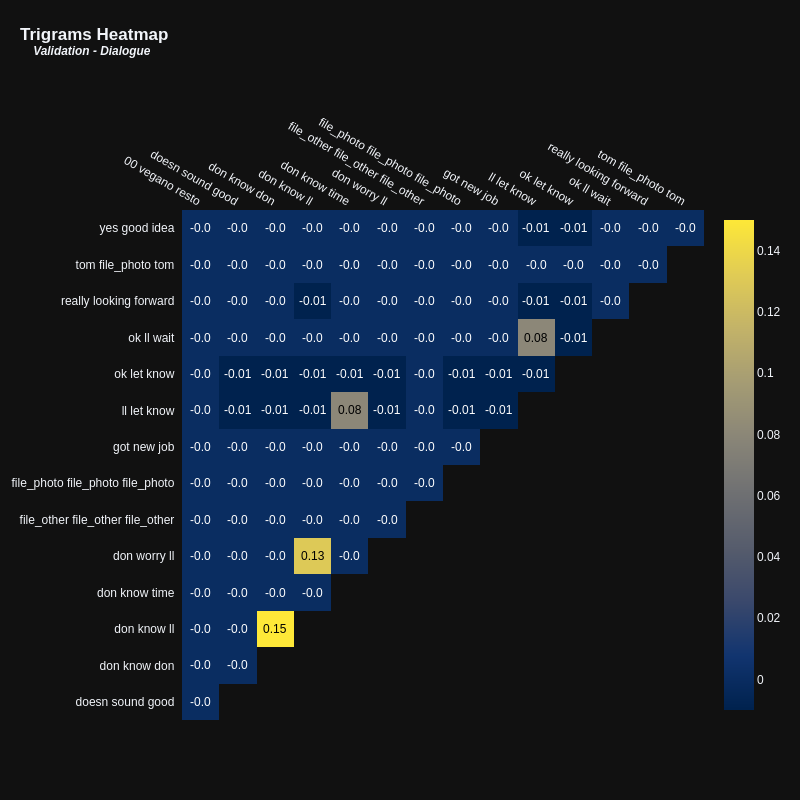

In [109]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(val['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Validation - Dialogue', 800, 800, 12)

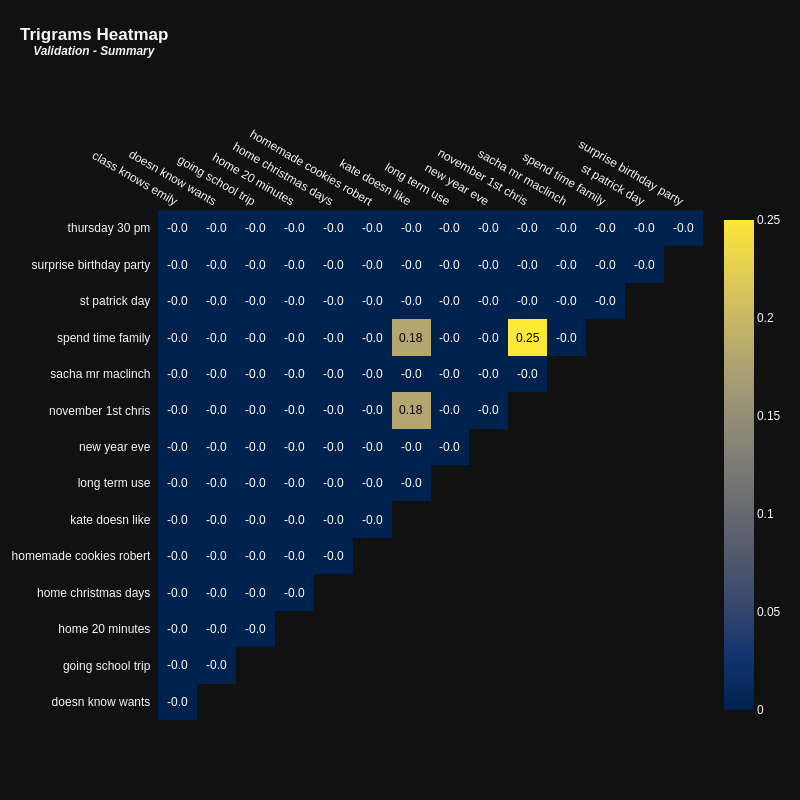

In [110]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(val['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Validation - Summary', 800, 800, 12)

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Overall, we have similar patterns across all the three datasets. Summaries are shorter in length than dialogues—as expected—and lots of terms that seem reasonable to be together have a higher degree of correlation.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">By analyzing the <i>n-grams</i> heatmaps, it is also clear that this data consists of chat/dialogue texts, since we can see a lot of terms that would usuallly appear in conversations.</p>

<div id = 'preprocess'
     style="font-family: Calibri, serif; text-align: left;">
    <hr style="border: none;
               border-top: 2.85px solid #041445;
               width: 100%;
               margin-top: 62px;
               margin-bottom: auto;
               margin-left: 0;">
    <div style="font-size: 35px; letter-spacing: 2.25px;color: #02011a;"><b>Preprocessing Data</b></div>
</div>

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">One of the main advantages of working with pre-trained models, such as BART, is that these models are usually extremely robust and require very little data preprocessing.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">While performing the EDA, I noticed that we have some tags in a few texts, such as <code>file_photo</code>. Let's take a look at a few examples.</p>

In [48]:
print(train['dialogue'].iloc[14727])

Theresa: <file_photo>
Theresa: <file_photo>
Theresa: Hey Louise, how are u?
Theresa: This is my workplace, they always give us so much food here 😊
Theresa: Luckily they also offer us yoga classes, so all the food isn't much of a problem 😂
Louise: Hey!! 🙂 
Louise: Wow, that's awesome, seems great 😎 Haha
Louise: I'm good! Are you coming to visit Stockholm this summer? 🙂
Theresa: I don't think so :/ I need to prepare for Uni.. I will probably attend a few lessons this winter
Louise: Nice! Do you already know which classes you will attend?
Theresa: Yes, it will be psychology :) I want to complete a few modules that I missed :)
Louise: Very good! Is it at the Uni in Prague?
Theresa: No, it will be in my home town :)
Louise: I have so much work right now, but I will continue to work until the end of summer, then I'm also back to Uni, on the 26th September!
Theresa: You must send me some pictures, so I can see where you live :) 
Louise: I will, and of my cat and dog too 🤗
Theresa: Yeeeesss pl

In [49]:
print(test['dialogue'].iloc[0])

Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye


<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">I am going to use the <code>clean_tags</code> function defined below to remove these tags from the texts, so we can make them cleaner.</p>

In [50]:
def clean_tags(text):
    clean = re.compile('<.*?>') # Compiling tags
    clean = re.sub(clean, '', text) # Replacing tags text by an empty string

    # Removing empty dialogues
    clean = '\n'.join([line for line in clean.split('\n') if not re.match('.*:\s*$', line)])

    return clean

In [51]:
test1 = clean_tags(train['dialogue'].iloc[14727]) # Applying function to example text
test2 = clean_tags(test['dialogue'].iloc[0]) # Applying function to example text

# Printing results
print(test1)
print('\n' *3)
print(test2)

Theresa: Hey Louise, how are u?
Theresa: This is my workplace, they always give us so much food here 😊
Theresa: Luckily they also offer us yoga classes, so all the food isn't much of a problem 😂
Louise: Hey!! 🙂 
Louise: Wow, that's awesome, seems great 😎 Haha
Louise: I'm good! Are you coming to visit Stockholm this summer? 🙂
Theresa: I don't think so :/ I need to prepare for Uni.. I will probably attend a few lessons this winter
Louise: Nice! Do you already know which classes you will attend?
Theresa: Yes, it will be psychology :) I want to complete a few modules that I missed :)
Louise: Very good! Is it at the Uni in Prague?
Theresa: No, it will be in my home town :)
Louise: I have so much work right now, but I will continue to work until the end of summer, then I'm also back to Uni, on the 26th September!
Theresa: You must send me some pictures, so I can see where you live :) 
Louise: I will, and of my cat and dog too 🤗
Theresa: Yeeeesss pls :)))
Louise: 👌👌
Theresa: 🐱💕




Hannah: He

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">You can see that we have successfully removed the tags from the texts. I am now going to define the <code>clean_df</code> function, in which we will apply the <code>clean_tags</code> to the entire datasets.</p>

In [52]:
# Defining function to clean every text in the dataset.
def clean_df(df, cols):
    for col in cols:
        df[col] = df[col].fillna('').apply(clean_tags)
    return df

In [53]:
# Cleaning texts in all datasets
train = clean_df(train,['dialogue', 'summary'])
test = clean_df(test,['dialogue', 'summary'])
val = clean_df(val,['dialogue', 'summary'])

In [54]:
train.tail(3) # Visualizing results

,id,dialogue,summary
14729,13819050,"John: Every day some bad news. Japan will hunt whales again\r\nErica: Yes, I've read this. It's very upsetting\r\nJohn: Cruel Japanese\r\nFaith: I think this is a racist remark. Because Island and Norways has never joined this international whaling agreement\r\nErica: really? I haven't known, everybody is so outraged by Japan\r\nFaith: sure, European hypocrisy \r\nJohn: not entirely. Scandinavians don't use the nets that Japanese use, so Norway and Island kill much less specimens that Japan will\r\nFaith: oh, it's much more complex than one may expect\r\nJohn: True, but the truth is, that all of them should stop\r\nJohn: and this decision is a step back\r\nFaith: yes, this is worrying\r\nErica: And it seems that the most important whaling countries are out of the agreement right now\r\nFaith: yes, seems so\r\nJohn: Just like USA leaving the Paris Agreement",Japan is going to hunt whales again. Island and Norway never stopped hunting them. The Scandinavians kill fewer whales than the Japanese.
14730,13828395,"Jennifer: Dear Celia! How are you doing?\r\nJennifer: The afternoon with the Collins was very pleasant, nice folks, but we missed you.\r\nJennifer: But I appreciate your consideration for Peter.\r\nCelia: My dear Jenny! It turns out that my decision not to come, though I wanted so much to see you again and Peter and the Collins, was right. Yesterday it all developed into a full bore cold. Sh.....\r\nCelia: All symptoms like in a text book.\r\nCelia: Luckily it's contagious only on the first 2, 3 days, so when we meet next week it should be alright.\r\nCelia: Thanks for asking! Somehow for all of us Peter comes first now.\r\nJennifer: That's too bad. Poor you...\r\nJennifer: I'll be driving to FR, do you want me to bring you sth? It's on my way.\r\nCelia: Thank you dear! I was at the pharmacy yesterday and had done my shopping the day before.\r\nCelia: You'd better still stay away from me in case I'm still contagious\r\nJennifer: Right. So I'll only leave a basket on your terrace. A...","Celia couldn't make it to the afternoon with the Collins and Jennifer as she is ill. She's working, but doesn't want to meet with Jennifer as it might be contagious. Jennifer will leave a basket with cookies on Celia's terrace."
14731,13729017,"Georgia: are you ready for hotel hunting? We need to book something finally for Lisbon\r\nJuliette: sure we can go on, show me what you found\r\nJuliette: nah... it looks like an old lady's room lol\r\nJuliette: that's better... but the bed doesn't look very comfortable\r\nGeorgia: i kind of like it and it's really close to the city center\r\nJuliette: show me the others please\r\nJuliette: nah... this one sucks too, look at those horrible curtains \r\nGeorgia: aff Julie you are such a princess\r\nJuliette: i just want to be comfortable\r\nGeorgia: come on, stop whining you know we are on a budget\r\nJuliette: well hopefully we can find something that's decent right?\r\nGeorgia: i did show you decent but you want a Marriott or something :/\r\nJuliette: ok ok don't get angry\r\nGeorgia: we need to decide today, the longer we wait the higher the prices get \r\nJuliette: ok how about we get the second one then?\r\nGeorgia: ok give me a second\r\nJuliette: sure\r\nGeorgia: affff someon...","Georgia and Juliette are looking for a hotel in Lisbon. Juliette dislikes Georgia's choices. Juliette and Georgia decide on the second option presented by Georgia, but it has already been booked. Finally Georgia books the third hotel."


<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">The tags have been removed from the texts. It's beneficial to conduct such data cleansing to eliminate noise—information that might not significantly contribute to the overall context and could potentially impair performance.</p>

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">I am now going to perform some preprocessing that is necessary to prepare our data to serve as input to the pre-trained model and for fine-tuning. Most of what I'm doing here is a part of the tutorial on Text Summarization described in the huggingface Transformers documentation, which you can see <a href ="https://huggingface.co/docs/transformers/tasks/summarization">here</a>.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">First, I am going to use the huggingface Datasets library to convert our Pandas Dataframes to Datasets. This is going to make our data ready to be processed across the whole Hugging Face ecosystem.</p>

In [55]:
from datasets import Dataset # Import the Dataset object
# Transforming dataframes into datasets
train_ds = Dataset.from_pandas(train)
test_ds = Dataset.from_pandas(test)
val_ds = Dataset.from_pandas(val)

# Visualizing results
print(train_ds)
print('\n' * 2)
print(test_ds)
print('\n' * 2)
print(val_ds)

Dataset({
    features: ['id', 'dialogue', 'summary', '__index_level_0__'],
    num_rows: 14731
})



Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 819
})



Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 818
})


<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">To see the cotent inside a huggingface Dataset, we can select a specific row, as below.</p>

In [56]:
train_ds[0] # Visualizing the first row

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.',
 '__index_level_0__': 0}

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">This way, we can see the original ID, the dialogue, as well as the reference summary. <code>__index_level_0__</code> does not add anything to the data and will be removed further.</p>

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">After successfully converting the pandas dataframes to huggingface Datasets, we can move on to the modeling process.</p>

<div id = 'modeling'
     style="font-family: Calibri, serif; text-align: left;">
    <hr style="border: none;
               border-top: 2.85px solid #041445;
               width: 100%;
               margin-top: 62px;
               margin-bottom: auto;
               margin-left: 0;">
    <div style="font-size: 30px; letter-spacing: 2.25px;color: #02011a;"><b>Modeling</b></div>
</div>

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Now, we are going to fine-tune a version of BART that has been trained on several news articles for text summarization, <a href ="https://huggingface.co/facebook/bart-large-xsum"><b>facebook/bart-large-xsum</b></a>.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">I will briefly demonstrate this model by loading a summarization pipeline with it to show you how it works on news data.</p>

In [57]:
# Loading summarization pipeline with the bart-large-cnn model
summarizer = pipeline('summarization', model = 'facebook/bart-large-xsum')

config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/309 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">As an example, I am going to use the following news article, published on CNN on October 24<sup>th</sup>, 2023, <i><a href ="https://edition.cnn.com/2023/10/24/europe/bobi-oldest-ever-dog-dies-intl-scli/index.html">Bobi, the world’s oldest dog ever, dies aged 31</a></i>. Notice that this is a totally unseen news article that I'm passing to the model, so we can see how it performs.</p>

In [58]:
news = '''Bobi, the world’s oldest dog ever, has died after reaching the almost inconceivable age of 31 years and 165 days, said Guinness World Records (GWR) on Monday.
His death at an animal hospital on Friday was initially announced by veterinarian Dr. Karen Becker.
She wrote on Facebook that “despite outliving every dog in history, his 11,478 days on earth would never be enough, for those who loved him.”
There were many secrets to Bobi’s extraordinary old age, his owner Leonel Costa told GWR in February. He always roamed freely, without a leash or chain, lived in a “calm, peaceful” environment and ate human food soaked in water to remove seasonings, Costa said.
He spent his whole life in Conqueiros, a small Portuguese village about 150 kilometers (93 miles) north of the capital Lisbon, often wandering around with cats.
Bobi was a purebred Rafeiro do Alentejo – a breed of livestock guardian dog – according to his owner. Rafeiro do Alentejos have a life expectancy of about 12-14 years, according to the American Kennel Club.
But Bobi lived more than twice as long as that life expectancy, surpassing an almost century-old record to become the oldest living dog and the oldest dog ever – a title which had previously been held by Australian cattle-dog Bluey, who was born in 1910 and lived to be 29 years and five months old.
However, Bobi’s story almost had a different ending.
When he and his three siblings were born in the family’s woodshed, Costa’s father decided they already had too many animals at home.
Costa and his brothers thought their parents had taken all the puppies away to be destroyed. However, a few sad days later, they found Bobi alive, safely hidden in a pile of logs.
The children hid the puppy from their parents and, by the time Bobi’s existence became known, he was too old to be put down and went on to live his record-breaking life.
His 31st birthday party in May was attended by more than 100 people and a performing dance troupe, GWR said.
His eyesight deteriorated and walking became harder as Bobi grew older but he still spent time in the backyard with the cats, rested more and napped by the fire.
“Bobi is special because looking at him is like remembering the people who were part of our family and unfortunately are no longer here, like my father, my brother, or my grandparents who have already left this world,” Costa told GWR in May. “Bobi represents those generations.”
'''
summarizer(news) # Using the pipeline to generate a summary of the text above

[{'summary_text': 'The world’s oldest dog has died, Guinness World Records has confirmed.'}]

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">You can observe that the model is able to accurately produce a much shorter text consisting of the most relevant information present in the input text. This is a successful summarization.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">However, this model has been trained mainly on datasets consisting of several news articles from CNN and the Daily Mail, not on much dialogue data. This is why I'm going to fine-tune it with the SamSum dataset.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Let's go ahead and load BartTokenizer and BartForConditionalGeneration using the <i><b>facebook/bart-large-xsum</b></i> checkpoint.</p>

In [59]:
checkpoint = 'facebook/bart-large-xsum' # Model
tokenizer = BartTokenizer.from_pretrained(checkpoint) # Loading Tokenizer

In [60]:
model = BartForConditionalGeneration.from_pretrained(checkpoint) # Loading Model

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">We can also print below the architecture of the model.</p>

In [61]:
print(model) # Visualizing model's architecture

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
    

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">It is possible to see that the models consist of an encoder and a decoder, we can see the Linear Layers, as well as the activation functions, which use $GeLU$, instead of the more typical $ReLU$.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">It is also interesting to observe the output layer, <b>lm_head</b>, which shows us that this model is ideal for generating outputs with a vocabulary size—<code>out_features=50264</code>—this shows us that this architecture is adequate for summarization tasks, as well as other tasks, such as translation for example.</p>

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Now we must preprocess our datasets and use BartTokenizer so that our data is legible for the BART model.</p>

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">The following <code>preprocess_function</code> can be directly copied from the 🤗 Transformers documentation, and it serves well to preprocess data for several NLP tasks. I am going to delve a bit deeper into how it preprocesses the data by explaining the steps it takes.</p>

<div style = "margin-left: 25px;">
    
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a"><b>• <code>inputs = [doc for doc in examples["dialogue"]]:</code></b> In this line, we are iterating over every <code>dialogue</code> in the dataset and saving them as input to the model.</p>
    
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a"><b>• <code>model_inputs = tokenizer(inputs, max_length=1024, truncation=True)
:</code></b> Here, we are using the <code>tokenizer</code> to convert the input dialogues into tokens that can be easily understood by the BART model. The <code>truncation=True</code> parameter ensures that all dialogues have a maximum number of 1024 tokens, as defined by the <code>max_length</code> parameter.</p>
    
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a"><b>• <code>labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True):</code></b> This line performs a very similar tokenization process as the one above. This time, however, it tokenizes the target variable, which is our summaries. Also, note that the max_length here is significantly lower, at 128. This implies that we expect summaries to be a much shorter text than that of dialogues.</p>
    
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a"><b>• <code>model_inputs["labels"] = labels["input_ids"]:</code></b> This line is essentially adding the tokenized labels to the preprocessed dataset, alongside the tokenized inputs.</p>
  
</div>

In [62]:
def preprocess_function(examples):
    inputs = [doc for doc in examples["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [63]:
# Applying preprocess_function to the datasets
tokenized_train = train_ds.map(preprocess_function, batched=True,
                               remove_columns=['id', 'dialogue', 'summary', '__index_level_0__']) # Removing features

tokenized_test = test_ds.map(preprocess_function, batched=True,
                               remove_columns=['id', 'dialogue', 'summary']) # Removing features

tokenized_val = val_ds.map(preprocess_function, batched=True,
                               remove_columns=['id', 'dialogue', 'summary']) # Removing features

# Printing results
print('\n' * 3)
print('Preprocessed Training Dataset:\n')
print(tokenized_train)
print('\n' * 2)
print('Preprocessed Test Dataset:\n')
print(tokenized_test)
print('\n' * 2)
print('Preprocessed Validation Dataset:\n')
print(tokenized_val)

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]





Preprocessed Training Dataset:

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 14731
})



Preprocessed Test Dataset:

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 819
})



Preprocessed Validation Dataset:

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 818
})


<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Our tokenized datasets consist now of only three features, <code>input_ids</code>, <code>attention_mask</code>, and <code>labels</code>. Let's print a sample from our tokenized train dataset to investigate further how the preprocess function altered the data.</p>

In [64]:
# Selecting a sample from the dataset
sample = tokenized_train[0]

# Printing its features
print("input_ids:")
print(sample['input_ids'])
print("\n")
print("attention_mask:")
print(sample['attention_mask'])
print("\n")
print("sample:")
print(sample['labels'])
print("\n")

input_ids:
[0, 10127, 5219, 35, 38, 17241, 1437, 15269, 4, 1832, 47, 236, 103, 116, 50121, 50118, 39237, 35, 9136, 328, 50121, 50118, 10127, 5219, 35, 38, 581, 836, 47, 3859, 48433, 2]


attention_mask:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


sample:
[0, 10127, 5219, 17241, 15269, 8, 40, 836, 6509, 103, 3859, 4, 2]




<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Let's dive a deep further into what each feature means.</p>

<div style = "margin-left: 25px;">
    
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a"><b>• input_ids</b>: These are the token IDs mapped to the dialogues. Each token represents a word or subword that can be perfectly understood by the BART model. For instance, the number <i><b>5219</b></i> could be a map to a word like <i>"hello"</i> in BART's vocabulary. Each word has its unique token in this context.</p>
    
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a"><b>• attention_mask</b>: This mask indicates which tokens the model should pay attention to and which tokens should be ignored. This is often used in the context of padding—when some tokens are used to equalize the lengths of sentences—but most of these padding tokens do not hold any meaningful information, so the attention mask ensures the model does not focus on them. In the case of this specific sample, all tokens are masked as '1', meaning they are all relevant and none of them are used for padding.</p>
    
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a"><b>• labels</b>: Similarly to the first feature, these are token IDs obtained from the words and subwords in the summaries. These are the tokens that the model will be trained on to give as output.</p>
  
</div>

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">We must now use <code>DataCollatorForSeq2Seq</code> to batch the data. These data collators may also automatically apply some processing techniques, such as padding. They are important for the task of fine-tuning models and are also present in the 🤗 Transformers documentation for text summarization.</p>

In [65]:
# Instantiating Data Collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Next, I am going to load the ROUGE metrics and define a new function to evaluate the model.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">The <code>compute_metrics</code> function is also available in the documentation. In this function, we are basically extracting the model-generated summaries, as well as the human-generated summaries, and decoding them. We then use rouge to compare how similar they are to evaluate performance. </p>

In [66]:
metric = load('rouge') # Loading ROUGE Score

In [67]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred# Obtaining predictions and true labels

    # Decoding predictions
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Obtaining the true labels tokens, while eliminating any possible masked token (i.e., label = -100)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]


    # Computing rouge score
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # result = {key: value.mid.fmeasure * 100 for key, value in result.items()} # Extracting some results
    result = {key: value * 100 for key, value in result.items()} # Extracting some results - Removed .mid.fmeasure

    # Add mean-generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">We now use the <code>Seq2SeqTrainingArguments</code> class to set some relevant settings for fine-tuning. I will first define a directory to serve as output, and then define the evaluation strategy, learning rate, etc.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">This class can be quite extensive, with several different parameters. I highly suggest you take your time with <a href = "https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments">the documentation</a> to get familiar with them.</p>

In [68]:
# Defining parameters for training
'''
doc: https://huggingface.co/docs/transformers/v4.34.1/en/main_classes/trainer

'''
training_args = Seq2SeqTrainingArguments(
    output_dir = 'bart_samsum',
    evaluation_strategy = "epoch",
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_loss',
    seed = seed,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    report_to="none"
)

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Finally, the <code>Seq2SeqTrainer</code> class allows us to use <b>PyTorch</b> to fine-tune the model. In this class, we are basically defining the model, the training arguments, the datasets used for training and evaluation, the tokenizer, the data_collator, and the metrics.</p>

In [69]:
# Defining Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [70]:
trainer.train() # Training model

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,1.480900,1.519629,52.724300,27.964100,43.278200,48.552100,29.324800
2,1.103400,1.455579,53.156900,28.232200,44.152800,49.006400,28.611700
3,0.921500,1.506650,53.308300,28.323100,43.961800,49.059100,29.742400
4,0.793900,1.566090,53.175400,28.643100,43.828100,48.926100,30.357800


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 62, 'min_length': 11, 'early_stopping': True, 'num_beams': 6, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 62, 'min_length': 11, 'early_stopping': True, 'num_beams': 6, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a G

TrainOutput(global_step=3684, training_loss=1.0592366569593596, metrics={'train_runtime': 8495.211, 'train_samples_per_second': 6.936, 'train_steps_per_second': 0.434, 'total_flos': 4.31212187941847e+16, 'train_loss': 1.0592366569593596, 'epoch': 4.0})

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">We finally finished fine-tuning after 4 epochs. Since we had <code>load_best_model_at_end = True</code> in the training arguments, the Trainer automatically saves the model with the best performance, which in this case is the one with the lowest <code>Validation Loss</code>.</p>

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">The second epoch was the one with the lowest validation loss, at <code><b>1.443861</b></code>. It also achieved the highest <code>Rouge1</code> and <code>Rouge2</code> scores, as well as the highest <code>Rougelsum</code> score.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">I have not presented the <code><b>Rougelsum</b></code> score previously. According to <a href = "https://pypi.org/project/rouge-score/">the documentation</a> of the rouge-score library, we can conclude that this is similar to the RougeL score, but it measures content coverage at a sentence-by-sentence level, instead of the entire summary.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">The <code>Gen Len</code> column gives us the average length of the model-generated summaries. It is relevant to remember that we want short, yet informative, texts. In this case, the second epoch also yielded the shortest summaries on average.</p>

<div id = 'evaluating'
     style="font-family: Calibri, serif; text-align: left;">
    <hr style="border: none;
               border-top: 2.85px solid #041445;
               width: 100%;
               margin-top: 62px;
               margin-bottom: auto;
               margin-left: 0;">
    <div style="font-size: 35px; letter-spacing: 2.25px;color: #02011a;"><b>Evaluating and Saving Model</b></div>
</div>

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">After training and testing the model, we can evaluate its performance on the <code>validation</code> dataset. We can use the <code>evaluate</code> method for that.</p>

In [71]:
# Evaluating model performance on the tokenized validation dataset
validation = trainer.evaluate(eval_dataset = tokenized_val)
print(validation) # Printing results

{'eval_loss': 1.4165412187576294, 'eval_rouge1': 54.4074, 'eval_rouge2': 29.6345, 'eval_rougeL': 44.7626, 'eval_rougeLsum': 50.2063, 'eval_gen_len': 28.6333, 'eval_runtime': 320.6235, 'eval_samples_per_second': 2.551, 'eval_steps_per_second': 0.321, 'epoch': 4.0}


<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">This outputs the same scores we have previously seen during training and testing. Here, we can notice that we have even <b>higher</b> performance in every metric compared to the performance in the testing set. When it comes to <code>Gen Len</code>, we also have more concise summaries in the validation set.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Considering that our results seem to be satisfactory at this point, we can go ahead and use the <code>save_model</code> method to save our fine-tuned model in the <code>bart_finetuned_samsum</code> directory. We can also use the <code>shutil</code> package to save the model in a <i>zip</i> file.</p>

In [72]:
# Saving model to a custom directory
directory = "bart_finetuned_samsum"
trainer.save_model(directory)

# Saving model tokenizer
tokenizer.save_pretrained(directory)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 62, 'min_length': 11, 'early_stopping': True, 'num_beams': 6, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 2}


('bart_finetuned_samsum/tokenizer_config.json',
 'bart_finetuned_samsum/special_tokens_map.json',
 'bart_finetuned_samsum/vocab.json',
 'bart_finetuned_samsum/merges.txt',
 'bart_finetuned_samsum/added_tokens.json')

In [73]:
# Loading summarization pipeline and model
summarizer = pipeline('summarization', model = '/kaggle/working/bart_finetuned_samsum')

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">After loading the pipeline, we can now produce some summaries. I'll first start by using examples from the validation dataset, so we can compare our model-generated summaries to the reference summaries.</p>

In [74]:
# Obtaining a random example from the validation dataset
val_ds[35]

{'id': '13821488',
 'dialogue': "John: doing anything special?\r\nAlex: watching 'Millionaires' on tvn\r\nSam: me too! He has a chance to win a million!\r\nJohn: ok, fingers crossed then! :)",
 'summary': 'Alex and Sam are watching Millionaires.'}

In [75]:
text = "John: doing anything special?\r\nAlex: watching 'Millionaires' on tvn\r\nSam: me too! He has a chance to win a million!\r\nJohn: ok, fingers crossed then! :)"
summary = "Alex and Sam are watching Millionaires."
generated_summary = summarizer(text)

Your max_length is set to 62, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


In [76]:
print('Original Dialogue:\n')
print(text)
print('\n' * 2)
print('Reference Summary:\n')
print(summary)
print('\n' * 2)
print('Model-generated Summary:\n')
print(generated_summary)

Original Dialogue:

John: doing anything special?
Alex: watching 'Millionaires' on tvn
Sam: me too! He has a chance to win a million!
John: ok, fingers crossed then! :)



Reference Summary:

Alex and Sam are watching Millionaires.



Model-generated Summary:

[{'summary_text': "Alex and Sam are watching 'Millionaires' on tvn. John will keep his fingers crossed."}]


<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">The model-generated summary is just a bit longer than the reference summary, but it still captures quite well the content of the dialogue.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Let's see another example.</p>

In [77]:
val_ds[22]

{'id': '13727839',
 'dialogue': 'Madison: Hello Lawrence are you through with the article?\r\nLawrence: Not yet sir. \r\nLawrence: But i will be in a few.\r\nMadison: Okay. But make it quick.\r\nMadison: The piece is needed by today\r\nLawrence: Sure thing\r\nLawrence: I will get back to you once i am through.',
 'summary': 'Lawrence will finish writing the article soon.'}

In [78]:
text = "Madison: Hello Lawrence are you through with the article?\r\nLawrence: Not yet sir. \r\nLawrence: But i will be in a few.\r\nMadison: Okay. But make it quick.\r\nMadison: The piece is needed by today\r\nLawrence: Sure thing\r\nLawrence: I will get back to you once i am through."
summary = "Lawrence will finish writing the article soon."
generated_summary = summarizer(text)

print('Original Dialogue:\n')
print(text)
print('\n' * 2)
print('Reference Summary:\n')
print(summary)
print('\n' * 2)
print('Model-generated Summary:\n')
print(generated_summary)

Original Dialogue:

Madison: Hello Lawrence are you through with the article?
Lawrence: Not yet sir. 
Lawrence: But i will be in a few.
Madison: Okay. But make it quick.
Madison: The piece is needed by today
Lawrence: Sure thing
Lawrence: I will get back to you once i am through.



Reference Summary:

Lawrence will finish writing the article soon.



Model-generated Summary:

[{'summary_text': "Lawrence hasn't finished with the article yet, but will do it in a few minutes. Madison needs it by today."}]


<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Once again, the model-generated summary is longer than the reference summary. However, I would definitely say that the model-generated summary is more informative than the reference one because it lets us know that there's a sense of urgency for Lawrence to finish the article since Madison needs it by today.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Let's see another example.</p>

In [79]:
val_ds[4]

{'id': '13728448',
 'dialogue': 'Robert: Hey give me the address of this music shop you mentioned before\r\nRobert: I have to buy guitar cable\r\nFred: Catch it on google maps\r\nRobert: thx m8\r\nFred: ur welcome',
 'summary': 'Robert wants Fred to send him the address of the music shop as he needs to buy guitar cable.'}

In [80]:
text = "Robert: Hey give me the address of this music shop you mentioned before\r\nRobert: I have to buy guitar cable\r\nFred: Catch it on google maps\r\nRobert: thx m8\r\nFred: ur welcome"
summary = "Robert wants Fred to send him the address of the music shop as he needs to buy guitar cable."
generated_summary = summarizer(text)

Your max_length is set to 62, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


In [81]:
print('Original Dialogue:\n')
print(text)
print('\n' * 2)
print('Reference Summary:\n')
print(summary)
print('\n' * 2)
print('Model-generated Summary:\n')
print(generated_summary)

Original Dialogue:

Robert: Hey give me the address of this music shop you mentioned before
Robert: I have to buy guitar cable
Fred: Catch it on google maps
Robert: thx m8
Fred: ur welcome



Reference Summary:

Robert wants Fred to send him the address of the music shop as he needs to buy guitar cable.



Model-generated Summary:

[{'summary_text': 'Robert needs to buy a guitar cable. Fred sends him the address of the music shop.'}]


<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">In this case, while the generated text captures the essence of the dialogue, it suffers from a lack of clarity due to ambiguity. Specifically, the pronoun <i>he</i> creates uncertainty about whether Fred or Robert intends to buy the guitar cable. In the original dialogue, it is clearly specified that it is Robert the one who has to buy the cable.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Now that we have been able to compare summaries, we can create some dialogues and input them into the model to check how it performs on them.</p>

In [82]:
# Creating new dialogues for evaluation
text = "John: Hey! I've been thinking about getting a PlayStation 5. Do you think it is worth it? \r\nDan: Idk man. R u sure ur going to have enough free time to play it? \r\nJohn: Yeah, that's why I'm not sure if I should buy one or not. I've been working so much lately idk if I'm gonna be able to play it as much as I'd like."
generated_summary = summarizer(text)

In [83]:
print('Original Dialogue:\n')
print(text)
print('\n' * 2)
print('Model-generated Summary:\n')
print(generated_summary)

Original Dialogue:

John: Hey! I've been thinking about getting a PlayStation 5. Do you think it is worth it? 
Dan: Idk man. R u sure ur going to have enough free time to play it? 
John: Yeah, that's why I'm not sure if I should buy one or not. I've been working so much lately idk if I'm gonna be able to play it as much as I'd like.



Model-generated Summary:

[{'summary_text': "John is thinking about getting a PlayStation 5. He's been working a lot lately, so he's not sure if he's going to have time to play it."}]


<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">For this dialogue, I have decided to include some abbreviations such as <i>idk</i>—for <i>I don't know</i>—and <i>r u</i>—for <i>are you</i>— to observe how the model would interpret them.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">We can see that the model has been able to successfully capture the essence of the dialogue and identify the main subject, which is John's uncertainty to buy a PlayStation 5 given the fact that he has so little time to play it.</p>

In [84]:
text = "Camilla: Who do you think is going to win the competition?\r\nMichelle: I believe Jonathan should win but I'm sure Mike is cheating!\r\nCamilla: Why do you say that? Can you prove Mike is really cheating?\r\nMichelle: I can't! But I just know!\r\nCamilla: You shouldn't accuse him of cheating if you don't have any evidence to support it."
generated_summary = summarizer(text)

In [85]:
print('Original Dialogue:\n')
print(text)
print('\n' * 2)
print('Model-generated Summary:\n')
print(generated_summary)

Original Dialogue:

Camilla: Who do you think is going to win the competition?
Michelle: I believe Jonathan should win but I'm sure Mike is cheating!
Camilla: Why do you say that? Can you prove Mike is really cheating?
Michelle: I can't! But I just know!
Camilla: You shouldn't accuse him of cheating if you don't have any evidence to support it.



Model-generated Summary:

[{'summary_text': 'Michelle believes Jonathan should win the competition, but she suspects Mike is cheating.'}]


<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">Once more the model captures the main theme of the conversation, which is Michelle's belief that Jonathan should win the competition, but that Mike may be cheating. Some further improvements could be made, though, such as including the information that Michelle cannot really show any evidence to support her belief that Mike is cheating.</p>

<div id = 'conclusion'
     style="font-family: Calibri, serif; text-align: left;">
    <hr style="border: none;
               border-top: 2.85px solid #041445;
               width: 100%;
               margin-top: 62px;
               margin-bottom: auto;
               margin-left: 0;">
    <div style="font-size: 35px; letter-spacing: 2.25px;color: #02011a;"><b>Conclusion and Deployment </b></div>
</div>

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">In this notebook, I have explored how we can use <b><i>Large Language Models</i></b> for several tasks involving Natural Language Processing, more specifically, Text Summarization tasks.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">I delved into how Hugging Face's Transformers, Evaluate, and Datasets can be used to leverage frameworks such as PyTorch to fine-tune pre-trained models with a large number of parameters. This type of technique is usually referred to as <b>transfer learning</b>, which allows Data Scientists and Machine Learning Engineers to exploit the knowledge gained from previous tasks to improve generalization on a new task.</p>
          
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 20px; letter-spacing: .85px;color: #02011a">I used a BART model that has been already trained to perform summarization on news articles and fine-tuned it to perform summarizations of dialogues with the <b>SamSum</b> dataset.</p>
          
